## Final Project Submission

* Student name: Jim Petoskey
* Student pace: Self-paced
* Scheduled project review date/time: Friday Feb 25, 2022 at 10:30 am 
* Instructor name: Abhineet Kulkarni
* [Blog post URL:](https://dev.to/jpetoskey/interpreting-coefficients-1c35)


# Return on Renovation
* For homeowners looking to invest in their property, what renovations offer the best return?
    * This project explores a variety of home price predictors to recommend which renovations are likely to increase sale price.

# Exploring Data

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from itertools import combinations
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import MissingIndicator
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from scipy.stats import zscore
import random

%matplotlib inline

In [2]:
house_df = pd.read_csv('data/kc_house_data.csv')
#column_names = pd.read_csv('data/column_names.md')

## What's in kc_house_data?

In [3]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
house_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,8 Good,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


# First Model - Baseline

## Use 3-4 predictors from numerical data in the King County Housing data set to create baseline model.

In [5]:
# set numerical data in new data frame
numericals = house_df[['bedrooms', 
                       'bathrooms', 
                       'sqft_living', 
                       'sqft_lot', 
                       'floors',
                       'sqft_above',
                       'yr_built',
                       'yr_renovated',
                       'zipcode', 
                       'sqft_living15', 
                       'sqft_lot15']]

# set target column
y = house_df['price']

numericals.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,1180,1955,0.0,98178,1340,5650
1,3,2.25,2570,7242,2.0,2170,1951,1991.0,98125,1690,7639
2,2,1.00,770,10000,1.0,770,1933,NaN,98028,2720,8062
3,4,3.00,1960,5000,1.0,1050,1965,0.0,98136,1360,5000
4,3,2.00,1680,8080,1.0,1680,1987,0.0,98074,1800,7503


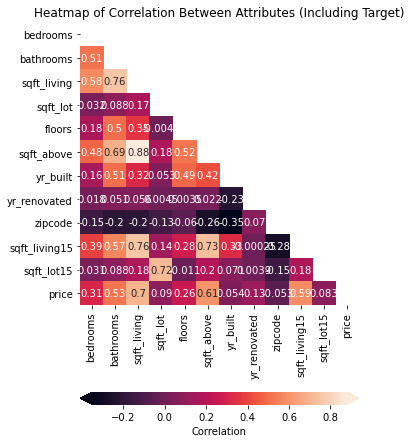

In [6]:
# Create a df with the target as the first column,
# then compute the correlation matrix
heatmap_data = pd.concat([numericals, y], axis=1)
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(5, 8))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

### Build a model with the top three numerical values, then I will examine and likely add-in categoricals after one-hot-encoding the non-numericals.

* The top three predictors are: sqft_living, (dropping sqft_above and sqft_living15 - see explanation below), bathrooms, and bedrooms.

* I will drop two of the three sqft_living, sqft_living15, and sqft_above because they  exhibit strong correlation to each other and likely strong multicollinearity.  Considering sqft_living has a stronger correlation to price, which is our target, I will drop sqft_living15 and sqft_above.

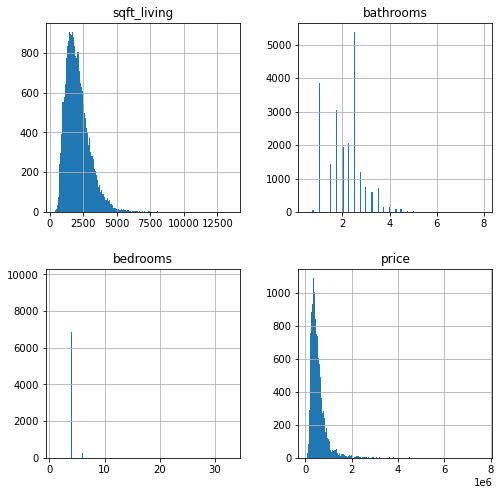

In [7]:
# Set top three numerical values
t3_numericals = house_df[['sqft_living', 'bathrooms', 'bedrooms', 'price']]

# Look at histograms for patterns
t3_numericals.hist(figsize = [8, 8], bins='auto');

### Log Tranformations
* Remove outliers later - especially in the bedrooms and sqft_living categories.

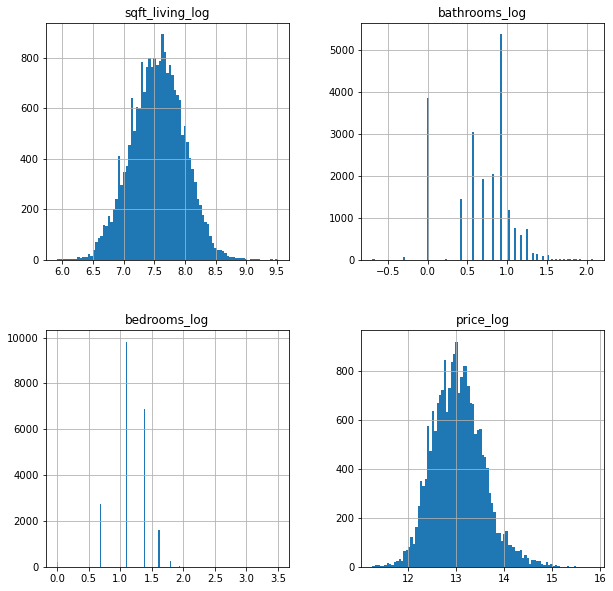

In [8]:
# Perform log transformations for t3_numericals 

log_names = [f'{column}_log' for column in t3_numericals.columns]

house_log = np.log(t3_numericals)
house_log.columns = log_names
house_log.hist(figsize=(10, 10), bins='auto')
fig.tight_layout();

### Normalization
* Skewness from outliers reduced with the log function performed.

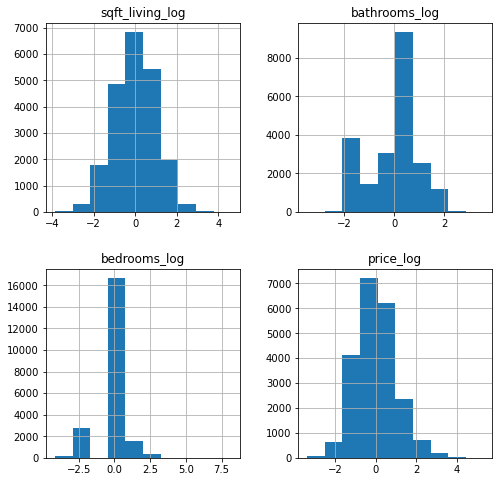

In [9]:
# Standardize the log features

def normalize(feature):
    return (feature - feature.mean()) / feature.std()

features_final = house_log.apply(normalize)

features_final.hist(figsize  = [8, 8]);

In [10]:
features_final.head()

,sqft_living_log,bathrooms_log,bedrooms_log,price_log
0,-1.125556,-1.726509,-0.279718,-1.401998
1,0.709446,0.339653,-0.279718,0.279938
2,-2.131893,-1.726509,-1.711611,-1.799430
3,0.070674,1.072635,0.736226,0.499698
4,-0.292725,0.039555,-0.279718,0.178434


In [11]:
# Model Summary
X = features_final.drop(['price_log'], axis=1)
y = features_final['price_log']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     6414.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:19:45   Log-Likelihood:                -23764.
No. Observations:               21597   AIC:                         4.754e+04
Df Residuals:                   21593   BIC:                         4.757e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.343e-15      0.005   2.71e-13      1.000      -0.010       0.010
sqft_living_log     0.7572      0.008     89.141      0.000       0.741       0.774
bathrooms_log       0.0325      0.008      4.244      0.000       0.017       0.047
bedrooms_log       -0.1652      0.007    -25.342      0.000      -0.178      -0.152
==============================================================================
Omnibus:                      104.465   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.162
Skew:                           0.139   Prob(JB):                     2.93e-22
Kurtosis:                       2.820   Cond. No.                         3.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
first_model = features_final

## Baseline Model - moderate R-squared value, good p-values, condition number, and identical Adjusted R-squared value.

* The R-squared value is not very high, but hopefully it will increase after I modify some of the data and include categorical variables.  This seems like a solid baseline model to work from as the p-values for the predictors fall far below the threshold of 5%, the condition number is low, indicating low multicollinearity, the standard errors are all far lower than the values of the coefficients, and the adjusted R-squared value is identical to the R-squared value, indicating we have a very low bias.

* As I alter the model, likely increasing complexity in order to increase the predictive capacity of the model, the adjusted R-squared value will probably not maintain equality or near-equality with the R-squared value.

## Train, Test, Split - First Model

In [13]:
X = first_model.drop('price_log', axis=1)
y = first_model['price_log']

In [14]:
# Split the data into training and test sets. Changed split size based on 
# the evaluation of train-test-split size below.  40% test size had a lower
# average variance than 25% or 30%.

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4)

# A brief preview of tts
print(len(X_train), len(X_test), len(y_train), len(y_test))

12958 8639 12958 8639


In [15]:
linreg = LinearRegression()

In [16]:
# Fit the model to train data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression()

In [17]:
# Calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [18]:
# Calculate residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [19]:
# Calculate training and test MSE
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 0.5410564176276695
Test Mean Squared Error: 0.5107553925929458


## Evaluate the effect of train-test split size.

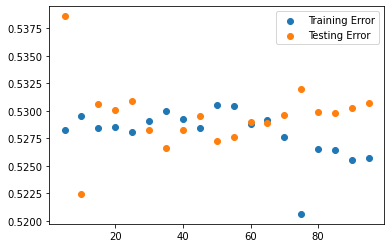

In [20]:
random.seed(900)

train_err = []
test_err = []
t_sizes = range(5,100,5)
for t_size in t_sizes:
    temp_train_err = []
    temp_test_err = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        temp_train_err.append(mean_squared_error(y_train, y_hat_train))
        temp_test_err.append(mean_squared_error(y_test, y_hat_test))
    train_err.append(np.mean(temp_train_err))
    test_err.append(np.mean(temp_test_err))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()

# Preprocess Categorical Variables

Variable Descriptions for Categorical Variables.

In [21]:
# create categorical variable data set
categoricals = house_df[['waterfront', 
                         'view', 
                         'condition', 
                         'grade'
]]

preprocessed = categoricals

## Dropped columns - id, date, sqft_basement.
* I dropped these columns because sqft_living is already incorporated into the model and other sqft categories had strong correlation with each other and would likely cause issues due to multicollinarity.

In [22]:
categoricals.describe

<bound method NDFrame.describe of       waterfront  view  condition          grade
0            NaN  NONE    Average      7 Average
1             NO  NONE    Average      7 Average
2             NO  NONE    Average  6 Low Average
3             NO  NONE  Very Good      7 Average
4             NO  NONE    Average         8 Good
...          ...   ...        ...            ...
21592         NO  NONE    Average         8 Good
21593         NO  NONE    Average         8 Good
21594         NO  NONE    Average      7 Average
21595        NaN  NONE    Average         8 Good
21596         NO  NONE    Average      7 Average

[21597 rows x 4 columns]>

## Plot categoricals to look for correlation to price.

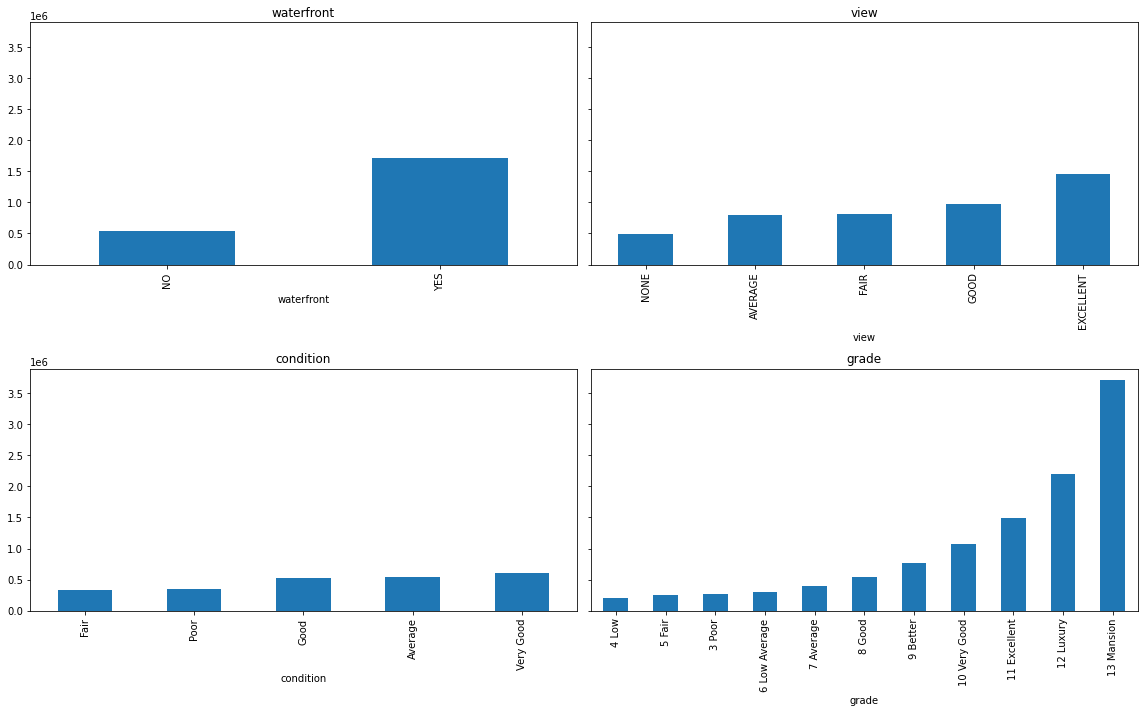

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10), sharey=True)

for col, ax in zip(categoricals, axes.flatten()):
    (house_df.groupby(col)               # group values together by column of interest
         .mean()['price']        # take the mean of the saleprice for each group
         .sort_values()              # sort the groups in ascending order
         .plot
         .bar(ax=ax))                # create a bar graph on the ax
    
    ax.set_title(col)                # Make the title the name of the column
    
fig.tight_layout()

### Promising Predictors - seem to correlate well with price from a visual inspection.

## Investigate nan values

In [24]:
categoricals.isnull().sum()

waterfront    2376
view            63
condition        0
grade            0
dtype: int64

In [25]:
# checking for nan values from categoricals['view']
categoricals['view'].value_counts(dropna=False)

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
NaN             63
Name: view, dtype: int64

In [26]:
# drops the whole row - removing some important data from other categories
# categoricals.dropna(subset=['waterfront'], inplace=True)

In [27]:
categoricals.isnull().sum()

waterfront    2376
view            63
condition        0
grade            0
dtype: int64

### Investigate nan values - waterfront

In [28]:
categoricals['waterfront'].value_counts(dropna=False)

NO     19075
NaN     2376
YES      146
Name: waterfront, dtype: int64

#### Create Missing Values Column - waterfront
* Saves nan information in the case that it is valuable later.

In [29]:
# (1) Identify data to be transformed
# We only want missing indicators for LotFrontage
waterfront_train = categoricals[["waterfront"]]

# (2) Instantiate the transformer object
missing_indicator = MissingIndicator()

# (3) Fit the transformer object on waterfront_train
missing_indicator.fit(waterfront_train)

# (4) Transform waterfront_train and assign the result
# to waterfront_missing_train
waterfront_missing_train = missing_indicator.transform(waterfront_train)

# Visually inspect waterfront_missing_train
waterfront_missing_train

array([[ True],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [False]])

##### Ensure waterfront_train is array of arrays containing True/False.

In [30]:
# waterfront_missing_train should be a NumPy array
assert type(waterfront_missing_train) == np.ndarray

# We should have the same number of rows as the full X_train
assert waterfront_missing_train.shape[0] == categoricals.shape[0]

# But we should only have 1 column
assert waterfront_missing_train.shape[1] == 1

In [31]:
# add the transformed data to the categorical data
categoricals["waterfront_missing"] = waterfront_missing_train
categoricals

<ipython-input-31-088c5258e668>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categoricals["waterfront_missing"] = waterfront_missing_train


,waterfront,view,condition,grade,waterfront_missing
0,NaN,NONE,Average,7 Average,True
1,NO,NONE,Average,7 Average,False
2,NO,NONE,Average,6 Low Average,False
3,NO,NONE,Very Good,7 Average,False
4,NO,NONE,Average,8 Good,False
...,...,...,...,...,...
21592,NO,NONE,Average,8 Good,False
21593,NO,NONE,Average,8 Good,False
21594,NO,NONE,Average,7 Average,False
21595,NaN,NONE,Average,8 Good,True


### Impute missing values for waterfront

In [32]:
# (1) waterfront_train was created previously, so we don't
# need to extract the relevant data again

# (2) Instantiate a SimpleImputer with strategy="most_frequent"
# use most_frequent due to non-numerical data
imputer = SimpleImputer(strategy="most_frequent")

# (3) Fit the imputer on waterfront_train
imputer.fit(waterfront_train)

# (4) Transform frontage_train using the imputer and
# assign the result to waterfront_imputed_train
waterfront_imputed_train = imputer.transform(waterfront_train)

# Visually inspect frontage_imputed_train
waterfront_imputed_train

array([['NO'],
       ['NO'],
       ['NO'],
       ...,
       ['NO'],
       ['NO'],
       ['NO']], dtype=object)

#### Replace original value of waterfront in categoricals with new values in waterfront_imputed_train.

In [33]:
# (5) Replace value of LotFrontage
categoricals["waterfront"] = waterfront_imputed_train

# Visually inspect X_train
categoricals

<ipython-input-33-76fe86732dd5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categoricals["waterfront"] = waterfront_imputed_train


,waterfront,view,condition,grade,waterfront_missing
0,NO,NONE,Average,7 Average,True
1,NO,NONE,Average,7 Average,False
2,NO,NONE,Average,6 Low Average,False
3,NO,NONE,Very Good,7 Average,False
4,NO,NONE,Average,8 Good,False
...,...,...,...,...,...
21592,NO,NONE,Average,8 Good,False
21593,NO,NONE,Average,8 Good,False
21594,NO,NONE,Average,7 Average,False
21595,NO,NONE,Average,8 Good,True


#### Check nan values for waterfront replaced.

In [34]:
categoricals.isnull().sum()

waterfront             0
view                  63
condition              0
grade                  0
waterfront_missing     0
dtype: int64

### Impute missing values for view

In [35]:
# (1) create view_train
view_train = categoricals[['view']]

# (2) Instantiate a SimpleImputer with strategy="most_frequent"
# use most_frequent due to non-numerical data
imputer = SimpleImputer(strategy="most_frequent")

# (3) Fit the imputer on waterfront_train
imputer.fit(view_train)

# (4) Transform frontage_train using the imputer and
# assign the result to waterfront_imputed_train
view_imputed_train = imputer.transform(view_train)

# Visually inspect frontage_imputed_train
view_imputed_train

array([['NONE'],
       ['NONE'],
       ['NONE'],
       ...,
       ['NONE'],
       ['NONE'],
       ['NONE']], dtype=object)

In [36]:
# (5) Replace value of view
categoricals["view"] = view_imputed_train

# Visually inspect X_train
categoricals

<ipython-input-36-7ff8ed9cd7c7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categoricals["view"] = view_imputed_train


,waterfront,view,condition,grade,waterfront_missing
0,NO,NONE,Average,7 Average,True
1,NO,NONE,Average,7 Average,False
2,NO,NONE,Average,6 Low Average,False
3,NO,NONE,Very Good,7 Average,False
4,NO,NONE,Average,8 Good,False
...,...,...,...,...,...
21592,NO,NONE,Average,8 Good,False
21593,NO,NONE,Average,8 Good,False
21594,NO,NONE,Average,7 Average,False
21595,NO,NONE,Average,8 Good,True


In [37]:
# nan values replaced with 'NONE'?
categoricals.isnull().sum()

waterfront            0
view                  0
condition             0
grade                 0
waterfront_missing    0
dtype: int64

## (skip) One-hot-encode Categoricals
* waterfront, view, condition, grade

### ohe waterfront

In [38]:
# (1) Create a variable street_train that contains the
# relevant column from X_train
# (Use double brackets [[]] to get the appropriate shape)
waterfront_train = categoricals[["waterfront"]]

# (2) Instantiate an OrdinalEncoder
encoder_waterfront = OrdinalEncoder()

# (3) Fit the encoder on street_train
encoder_waterfront.fit(waterfront_train)

# Inspect the categories of the fitted encoder
encoder_waterfront.categories_[0]

array(['NO', 'YES'], dtype=object)

In [39]:
# Encode waterfront type
waterfront_test = categoricals[["waterfront"]]
waterfront_encoded_test = encoder_waterfront.transform(waterfront_test).flatten()
categoricals["waterfront"] = waterfront_encoded_test

# Visually inspect categoricals
categoricals

<ipython-input-39-f7275cd5cd86>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categoricals["waterfront"] = waterfront_encoded_test


,waterfront,view,condition,grade,waterfront_missing
0,0.0,NONE,Average,7 Average,True
1,0.0,NONE,Average,7 Average,False
2,0.0,NONE,Average,6 Low Average,False
3,0.0,NONE,Very Good,7 Average,False
4,0.0,NONE,Average,8 Good,False
...,...,...,...,...,...
21592,0.0,NONE,Average,8 Good,False
21593,0.0,NONE,Average,8 Good,False
21594,0.0,NONE,Average,7 Average,False
21595,0.0,NONE,Average,8 Good,True


In [40]:
# visually inspect waterfront is a float64 data type
categoricals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   waterfront          21597 non-null  float64
 1   view                21597 non-null  object 
 2   condition           21597 non-null  object 
 3   grade               21597 non-null  object 
 4   waterfront_missing  21597 non-null  bool   
dtypes: bool(1), float64(1), object(3)
memory usage: 696.1+ KB


### ohe view

In [41]:
# (1) Create a variable view_train
# extracted from categoricals
# (double brackets due to shape expected by OHE)
view_train = categoricals[["view"]]

# (2) Instantiate a OneHotEncoder with categories="auto",
# sparse=False, and handle_unknown="ignore"
ohe = OneHotEncoder(categories="auto", sparse=False, handle_unknown="ignore")

# (3) Fit the encoder on fireplace_qu_train
ohe.fit(view_train)

# Inspect the categories of the fitted encoder
ohe.categories_

[array(['AVERAGE', 'EXCELLENT', 'FAIR', 'GOOD', 'NONE'], dtype=object)]

In [42]:
# (4) Transform view_train using the encoder and
# assign the result to view_encoded_train
view_encoded_train = ohe.transform(view_train)

# Visually inspect view_encoded_train
view_encoded_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [43]:
# (5a) Make the transformed data into a dataframe
view_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    view_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index=categoricals.index
)

# Visually inspect new dataframe
view_encoded_train

,AVERAGE,EXCELLENT,FAIR,GOOD,NONE
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
21592,0.0,0.0,0.0,0.0,1.0
21593,0.0,0.0,0.0,0.0,1.0
21594,0.0,0.0,0.0,0.0,1.0
21595,0.0,0.0,0.0,0.0,1.0


In [44]:
view_encoded_train = view_encoded_train.rename(columns={'Average':'View_Average',
                                        'EXCELLENT':'View_Excellent',
                                        'FAIR':'View_Fair',
                                        'GOOD':'View_Good',
                                        'NONE':'No View'})
view_encoded_train

,AVERAGE,View_Excellent,View_Fair,View_Good,No View
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
21592,0.0,0.0,0.0,0.0,1.0
21593,0.0,0.0,0.0,0.0,1.0
21594,0.0,0.0,0.0,0.0,1.0
21595,0.0,0.0,0.0,0.0,1.0


In [45]:
# (5b) Concatenate the new dataframe with current categoricals
categoricals = pd.concat([categoricals, view_encoded_train], axis=1)

# Visually inspect categoricals
categoricals

,waterfront,view,condition,grade,waterfront_missing,AVERAGE,View_Excellent,View_Fair,View_Good,No View
0,0.0,NONE,Average,7 Average,True,0.0,0.0,0.0,0.0,1.0
1,0.0,NONE,Average,7 Average,False,0.0,0.0,0.0,0.0,1.0
2,0.0,NONE,Average,6 Low Average,False,0.0,0.0,0.0,0.0,1.0
3,0.0,NONE,Very Good,7 Average,False,0.0,0.0,0.0,0.0,1.0
4,0.0,NONE,Average,8 Good,False,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
21592,0.0,NONE,Average,8 Good,False,0.0,0.0,0.0,0.0,1.0
21593,0.0,NONE,Average,8 Good,False,0.0,0.0,0.0,0.0,1.0
21594,0.0,NONE,Average,7 Average,False,0.0,0.0,0.0,0.0,1.0
21595,0.0,NONE,Average,8 Good,True,0.0,0.0,0.0,0.0,1.0


In [46]:
# (5c) Drop original view column
categoricals.drop("view", axis=1, inplace=True)

# Visually inspect X_train
categoricals

,waterfront,condition,grade,waterfront_missing,AVERAGE,View_Excellent,View_Fair,View_Good,No View
0,0.0,Average,7 Average,True,0.0,0.0,0.0,0.0,1.0
1,0.0,Average,7 Average,False,0.0,0.0,0.0,0.0,1.0
2,0.0,Average,6 Low Average,False,0.0,0.0,0.0,0.0,1.0
3,0.0,Very Good,7 Average,False,0.0,0.0,0.0,0.0,1.0
4,0.0,Average,8 Good,False,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
21592,0.0,Average,8 Good,False,0.0,0.0,0.0,0.0,1.0
21593,0.0,Average,8 Good,False,0.0,0.0,0.0,0.0,1.0
21594,0.0,Average,7 Average,False,0.0,0.0,0.0,0.0,1.0
21595,0.0,Average,8 Good,True,0.0,0.0,0.0,0.0,1.0


### ohe condition

In [47]:
categoricals['condition'].value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

In [48]:
# (1) Create a variable condition_train
# extracted from categoricals
# (double brackets due to shape expected by OHE)
condition_train = categoricals[["condition"]]

# (2) Fit the encoder on fireplace_qu_train
ohe.fit(condition_train)

# Inspect the categories of the fitted encoder
ohe.categories_

[array(['Average', 'Fair', 'Good', 'Poor', 'Very Good'], dtype=object)]

In [49]:
# (3) Transform condition_train using the encoder and
# assign the result to condition_encoded_train
condition_encoded_train = ohe.transform(condition_train)

# Visually inspect condition_encoded_train
condition_encoded_train

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [50]:
# (4a) Make the transformed data into a dataframe
condition_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    condition_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index=categoricals.index
)

# Visually inspect new dataframe
condition_encoded_train

,Average,Fair,Good,Poor,Very Good
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
21592,1.0,0.0,0.0,0.0,0.0
21593,1.0,0.0,0.0,0.0,0.0
21594,1.0,0.0,0.0,0.0,0.0
21595,1.0,0.0,0.0,0.0,0.0


In [51]:
condition_encoded_train = condition_encoded_train.rename(columns={'Average':'Condition_Average',
                                        'Fair':'Condition_Fair',
                                        'Good':'Condition_Good',
                                        'Poor':'Condition_Poor',
                                        'Very Good':'Condition_Very Good'})
condition_encoded_train

,Condition_Average,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very Good
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
21592,1.0,0.0,0.0,0.0,0.0
21593,1.0,0.0,0.0,0.0,0.0
21594,1.0,0.0,0.0,0.0,0.0
21595,1.0,0.0,0.0,0.0,0.0


In [52]:
# (4b) Concatenate the new dataframe with current categoricals
categoricals = pd.concat([categoricals, condition_encoded_train], axis=1)

# Visually inspect categoricals
categoricals

,waterfront,condition,grade,waterfront_missing,AVERAGE,View_Excellent,View_Fair,View_Good,No View,Condition_Average,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very Good
0,0.0,Average,7 Average,True,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,Average,7 Average,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,Average,6 Low Average,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.0,Very Good,7 Average,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,Average,8 Good,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0.0,Average,8 Good,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
21593,0.0,Average,8 Good,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
21594,0.0,Average,7 Average,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
21595,0.0,Average,8 Good,True,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [53]:
# (4c) Drop original condition column
categoricals.drop("condition", axis=1, inplace=True)

# Visually inspect X_train
categoricals

,waterfront,grade,waterfront_missing,AVERAGE,View_Excellent,View_Fair,View_Good,No View,Condition_Average,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very Good
0,0.0,7 Average,True,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,7 Average,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,6 Low Average,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.0,7 Average,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,8 Good,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0.0,8 Good,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
21593,0.0,8 Good,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
21594,0.0,7 Average,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
21595,0.0,8 Good,True,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


### ohe grade

In [54]:
categoricals['grade'].value_counts(dropna=False)

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

### Try ohe an easier way.

## One-Hot-Encode Simplified
* For waterfront, view, condition, and grade.

In [55]:
# use preprocessed categoricals data frame
cats = preprocessed

cats.isnull().sum()

waterfront            0
view                  0
condition             0
grade                 0
waterfront_missing    0
dtype: int64

In [56]:
water_dummies = pd.get_dummies(cats['waterfront'], prefix='water', drop_first=True)
view_dummies = pd.get_dummies(cats['view'], prefix='view', drop_first=True)
condition_dummies = pd.get_dummies(cats['condition'], prefix='condition', drop_first=True)
grade_dummies = pd.get_dummies(cats['grade'], prefix='grade', drop_first=True)

In [57]:
cats = cats.drop(['waterfront','view','condition','grade'], axis=1)

In [58]:
# create data frame with ohe features only
ohe_only = pd.concat([water_dummies,
                      view_dummies,
                      condition_dummies,
                      grade_dummies], axis=1)

# create data frame with numerical and categorical features
cats_added = pd.concat([features_final,
                        water_dummies,
                        view_dummies, 
                        condition_dummies,
                        grade_dummies], axis=1)
cats_added.head()

,sqft_living_log,bathrooms_log,bedrooms_log,price_log,water_1.0,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE,condition_Fair,...,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_3 Poor,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better
0,-1.125556,-1.726509,-0.279718,-1.401998,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0.709446,0.339653,-0.279718,0.279938,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,-2.131893,-1.726509,-1.711611,-1.799430,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0.070674,1.072635,0.736226,0.499698,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,-0.292725,0.039555,-0.279718,0.178434,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [59]:
ohe_only.head()

,water_1.0,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE,condition_Fair,condition_Good,condition_Poor,condition_Very Good,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_3 Poor,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [60]:
cats_added.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sqft_living_log      21597 non-null  float64
 1   bathrooms_log        21597 non-null  float64
 2   bedrooms_log         21597 non-null  float64
 3   price_log            21597 non-null  float64
 4   water_1.0            21597 non-null  uint8  
 5   view_EXCELLENT       21597 non-null  uint8  
 6   view_FAIR            21597 non-null  uint8  
 7   view_GOOD            21597 non-null  uint8  
 8   view_NONE            21597 non-null  uint8  
 9   condition_Fair       21597 non-null  uint8  
 10  condition_Good       21597 non-null  uint8  
 11  condition_Poor       21597 non-null  uint8  
 12  condition_Very Good  21597 non-null  uint8  
 13  grade_11 Excellent   21597 non-null  uint8  
 14  grade_12 Luxury      21597 non-null  uint8  
 15  grade_13 Mansion     21597 non-null 

# Second Model - Add Preprocessed Categoricals

In [61]:
# Model Summary
X = cats_added.drop(['price_log'], axis=1)
y = cats_added['price_log']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     1428.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:20:18   Log-Likelihood:                -20940.
No. Observations:               21597   AIC:                         4.193e+04
Df Residuals:                   21574   BIC:                         4.211e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.1265      0.029     38.395      0.000       1.069       1.184
sqft_living_log         0.3743      0.009     41.457      0.000       0.357       0.392
bathrooms_log          -0.0248      0.007     -3.487      0.000      -0.039      -0.011
bedrooms_log           -0.0633      0.006    -10.621      0.000      -0.075      -0.052
water_1.0               0.6641      0.065     10.268      0.000       0.537       0.791
view_EXCELLENT          0.3396      0.048      7.021      0.000       0.245       0.434
view_FAIR               0.1434      0.041      3.516      0.000       0.063       0.223
view_GOOD               0.0916      0.035      2.607      0.009       0.023       0.160
view_NONE              -0.3136      0.021    -14.618      0.000      -0.356      -0.272
condition_Fair         -0.2067      0.050     -4.156      0.000      -0.304      -0.109
condition_Good          0.1387      0.010     13.405      0.000       0.118       0.159
condition_Poor         -0.0726      0.120     -0.607      0.544      -0.307       0.162
condition_Very Good     0.4080      0.017     24.539      0.000       0.375       0.441
grade_11 Excellent      0.3832      0.037     10.248      0.000       0.310       0.456
grade_12 Luxury         0.8017      0.071     11.299      0.000       0.663       0.941
grade_13 Mansion        1.6063      0.179      8.987      0.000       1.256       1.957
grade_3 Poor           -1.4873      0.640     -2.325      0.020      -2.741      -0.234
grade_4 Low            -1.8405      0.127    -14.451      0.000      -2.090      -1.591
grade_5 Fair           -1.8029      0.050    -35.809      0.000      -1.902      -1.704
grade_6 Low Average    -1.5096      0.030    -49.974      0.000      -1.569      -1.450
grade_7 Average        -1.1863      0.024    -49.453      0.000      -1.233      -1.139
grade_8 Good           -0.8201      0.022    -36.777      0.000      -0.864      -0.776
grade_9 Better         -0.3903      0.023    -16.964      0.000      -0.435      -0.345
==============================================================================
Omnibus:                       21.045   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.154
Skew:                           0.055   Prob(JB):                     4.20e-05
Kurtosis:                       2.898   Cond. No.                         229.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Results of adding Categoricals
* Improved R-squared with only slightly lower Adjusted R-squared.
* Need to drop condition_poor due to high p-value.  This is probably a result of only having one data point for condition_poor.
* Can drop grade_3 Poor due to p-value over 1% to check if it improves the model's accuracy.

In [62]:
# Run model summary again without condition_Poor
second_model = cats_added.drop(['condition_Poor', 'grade_3 Poor'], axis=1)

# Model Summary
X = cats_added.drop(['price_log'], axis=1)
y = cats_added['price_log']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     1428.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:20:19   Log-Likelihood:                -20940.
No. Observations:               21597   AIC:                         4.193e+04
Df Residuals:                   21574   BIC:                         4.211e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.1265      0.029     38.395      0.000       1.069       1.184
sqft_living_log         0.3743      0.009     41.457      0.000       0.357       0.392
bathrooms_log          -0.0248      0.007     -3.487      0.000      -0.039      -0.011
bedrooms_log           -0.0633      0.006    -10.621      0.000      -0.075      -0.052
water_1.0               0.6641      0.065     10.268      0.000       0.537       0.791
view_EXCELLENT          0.3396      0.048      7.021      0.000       0.245       0.434
view_FAIR               0.1434      0.041      3.516      0.000       0.063       0.223
view_GOOD               0.0916      0.035      2.607      0.009       0.023       0.160
view_NONE              -0.3136      0.021    -14.618      0.000      -0.356      -0.272
condition_Fair         -0.2067      0.050     -4.156      0.000      -0.304      -0.109
condition_Good          0.1387      0.010     13.405      0.000       0.118       0.159
condition_Poor         -0.0726      0.120     -0.607      0.544      -0.307       0.162
condition_Very Good     0.4080      0.017     24.539      0.000       0.375       0.441
grade_11 Excellent      0.3832      0.037     10.248      0.000       0.310       0.456
grade_12 Luxury         0.8017      0.071     11.299      0.000       0.663       0.941
grade_13 Mansion        1.6063      0.179      8.987      0.000       1.256       1.957
grade_3 Poor           -1.4873      0.640     -2.325      0.020      -2.741      -0.234
grade_4 Low            -1.8405      0.127    -14.451      0.000      -2.090      -1.591
grade_5 Fair           -1.8029      0.050    -35.809      0.000      -1.902      -1.704
grade_6 Low Average    -1.5096      0.030    -49.974      0.000      -1.569      -1.450
grade_7 Average        -1.1863      0.024    -49.453      0.000      -1.233      -1.139
grade_8 Good           -0.8201      0.022    -36.777      0.000      -0.864      -0.776
grade_9 Better         -0.3903      0.023    -16.964      0.000      -0.435      -0.345
==============================================================================
Omnibus:                       21.045   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.154
Skew:                           0.055   Prob(JB):                     4.20e-05
Kurtosis:                       2.898   Cond. No.                         229.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Dropping condition_Poor and grade_3 Poor did not change the R-squared value.  
* This is likely because both categories represented a very small portion of the data.

### How does this compare with using sqft_living_log as the only predictor?

In [63]:
# Run model summary with only sqft_living_log

# Model Summary
X = cats_added['sqft_living_log']
y = cats_added['price_log']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                 1.805e+04
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:20:20   Log-Likelihood:                -24083.
No. Observations:               21597   AIC:                         4.817e+04
Df Residuals:                   21595   BIC:                         4.819e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.327e-15      0.005   2.64e-13      1.000      -0.010       0.010
sqft_living_log     0.6748      0.005    134.368      0.000       0.665       0.685
==============================================================================
Omnibus:                      123.577   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.096
Skew:                           0.143   Prob(JB):                     1.68e-25
Kurtosis:                       2.787   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### The model with bedrooms and bathrooms as numerical predictors and waterfront, view, condition, and grade as categorical predictors produces more accurate predictions than sqft_living alone.

## Second Model - Train, Test, Split

In [64]:
X2 = second_model.drop('price_log', axis=1)
y2 = second_model['price_log']

In [65]:
# Split the data into training and test sets. Use the default split size

X_train, X_test, y_train, y_test = train_test_split(X2,y2, test_size=.4)

# A brief preview of tts
print(len(X_train), len(X_test), len(y_train), len(y_test))

12958 8639 12958 8639


In [66]:
# Fit the model to train data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression()

In [67]:
# Calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [68]:
# Calculate residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [69]:
# Calculate training and test MSE
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 0.4030686652798846
Test Mean Squared Error: 0.4142283862843495


### Instantiate a Linear Regression model called final_model, then fit it to training data and score it on test data.

In [70]:
linreg = LinearRegression()

# Fit the model on X_train_final and y_train
linreg.fit(X_train, y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
linreg.score(X_test, y_test)

0.5902032218319748

### Model improvements from first to second models.
* Lower variance and lower bias present in second_model compared to first_model
    * Adjusted R-squared improved from 0.471 to 0.595
    * Mean Squared Error improved from 0.507/0.516 (train/test) to 0.404/0.413 (train/test).
***
* Mean squared error similar in train and test splits for both first and second models.
    * first_model: train = 0.507, test = 0.516
    * second_model: train = 0.404, test = 0.413

# Third Model - add more numerical values
* Which numerical values to add?
* Adds complexity and might hurt bias while improving variance.

In [71]:
# look at values for floors -- looks easy to implement
house_df['floors'].value_counts(dropna=False)

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

In [72]:
# too many issues with this column - could probably one hot encode
# all of the years, but that would create too many predictors.
house_df['yr_renovated'].value_counts(dropna=False)

0.0       17011
NaN        3842
2014.0       73
2003.0       31
2013.0       31
          ...  
1944.0        1
1948.0        1
1976.0        1
1934.0        1
1953.0        1
Name: yr_renovated, Length: 71, dtype: int64

In [73]:
# look at yr_built value_counts - easy to include this predictor
house_df['yr_built'].value_counts(dropna=False)

2014    559
2006    453
2005    450
2004    433
2003    420
       ... 
1933     30
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

In [74]:
add_numericals = house_df[['yr_built', 'floors']]

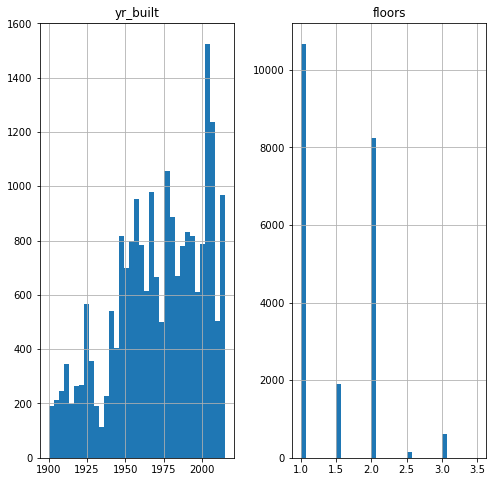

In [75]:
add_numericals.hist(figsize = [8,8], bins='auto');

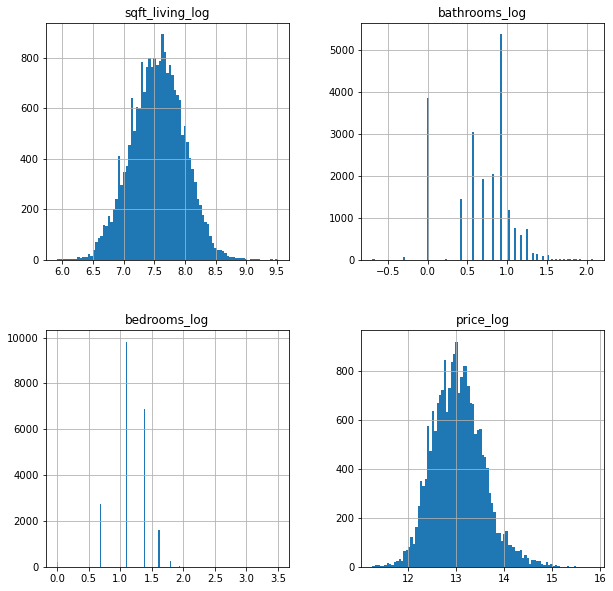

In [76]:
# Perform log transformations for add_numericals 

log_names = [f'{column}_log' for column in add_numericals.columns]

house_log2 = np.log(add_numericals)
house_log2.columns = log_names
house_log.hist(figsize=(10, 10), bins='auto')
fig.tight_layout();

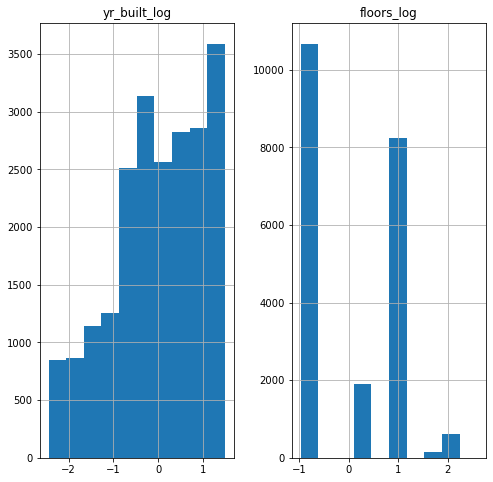

In [77]:
# Standardize the log features

def normalize(feature):
    return (feature - feature.mean()) / feature.std()

features_add = house_log2.apply(normalize)

features_add.hist(figsize  = [8, 8]);

### Additional features not normally distributed.
* Likely to cause skewness.

In [78]:
features_add.describe()

,yr_built_log,floors_log
count,2.159700e+04,2.159700e+04
mean,-2.568837e-15,2.105604e-17
std,1.000000e+00,1.000000e+00
min,-2.445050e+00,-9.608519e-01
25%,-6.743255e-01,-9.608519e-01
50%,1.430005e-01,1.901686e-01
75%,8.835377e-01,1.006831e+00
max,1.483389e+00,2.595449e+00


In [79]:
third_model = pd.concat([second_model, features_add], axis=1)
third_model.head()

,sqft_living_log,bathrooms_log,bedrooms_log,price_log,water_1.0,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE,condition_Fair,...,grade_12 Luxury,grade_13 Mansion,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,yr_built_log,floors_log
0,-1.125556,-1.726509,-0.279718,-1.401998,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,-0.537409,-0.960852
1,0.709446,0.339653,-0.279718,0.279938,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,-0.674325,1.006831
2,-2.131893,-1.726509,-1.711611,-1.799430,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,-1.293945,-0.960852
3,0.070674,1.072635,0.736226,0.499698,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,-0.196338,-0.960852
4,-0.292725,0.039555,-0.279718,0.178434,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0.547946,-0.960852


In [80]:
# Model Summary
X = third_model.drop(['price_log'], axis=1)
y = third_model['price_log']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     1811.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:20:30   Log-Likelihood:                -19347.
No. Observations:               21597   AIC:                         3.874e+04
Df Residuals:                   21574   BIC:                         3.892e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.1622      0.027     42.506      0.000       1.109       1.216
sqft_living_log         0.3183      0.008     37.644      0.000       0.302       0.335
bathrooms_log           0.1051      0.007     14.385      0.000       0.091       0.119
bedrooms_log           -0.0753      0.006    -13.587      0.000      -0.086      -0.064
water_1.0               0.6174      0.060     10.275      0.000       0.500       0.735
view_EXCELLENT          0.3314      0.045      7.374      0.000       0.243       0.419
view_FAIR               0.1558      0.038      4.114      0.000       0.082       0.230
view_GOOD               0.0785      0.033      2.407      0.016       0.015       0.143
view_NONE              -0.1946      0.020     -9.696      0.000      -0.234      -0.155
condition_Fair         -0.3082      0.046     -6.666      0.000      -0.399      -0.218
condition_Good          0.0279      0.010      2.780      0.005       0.008       0.048
condition_Very Good     0.1563      0.016      9.643      0.000       0.125       0.188
grade_11 Excellent      0.4015      0.035     11.559      0.000       0.333       0.470
grade_12 Luxury         0.8326      0.066     12.633      0.000       0.703       0.962
grade_13 Mansion        1.4383      0.166      8.662      0.000       1.113       1.764
grade_4 Low            -2.1558      0.118    -18.204      0.000      -2.388      -1.924
grade_5 Fair           -2.1173      0.047    -44.977      0.000      -2.210      -2.025
grade_6 Low Average    -1.7577      0.029    -61.252      0.000      -1.814      -1.701
grade_7 Average        -1.3080      0.023    -57.594      0.000      -1.353      -1.264
grade_8 Good           -0.8744      0.021    -42.062      0.000      -0.915      -0.834
grade_9 Better         -0.3916      0.021    -18.331      0.000      -0.433      -0.350
yr_built_log           -0.3198      0.005    -58.362      0.000      -0.331      -0.309
floors_log              0.0726      0.005     14.182      0.000       0.063       0.083
==============================================================================
Omnibus:                       54.593   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.004
Skew:                          -0.069   Prob(JB):                     2.08e-14
Kurtosis:                       3.226   Cond. No.                         71.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
X3 = third_model.drop('price_log', axis=1)
y3 = third_model['price_log']

In [82]:
# Split the data into training and test sets. Use the default split size

X_train, X_test, y_train, y_test = train_test_split(X3,y3, test_size=.4)

# A brief preview of tts
print(len(X_train), len(X_test), len(y_train), len(y_test))

12958 8639 12958 8639


In [83]:
linreg = LinearRegression()

# Fit the model to train data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression()

In [84]:
# Calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [85]:
# Calculate residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [86]:
# Calculate training and test MSE
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 0.3510884782857279
Test Mean Squared Error: 0.35215919912378846


### Instantiate a Linear Regression model called final_model, then fit it to training data and score it on test data.

In [87]:
linreg = LinearRegression()

# Fit the model on X_train_final and y_train
linreg.fit(X_train, y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
linreg.score(X_test, y_test)

0.6476544804916564

### Third model lowers Variance and Bias
* Adjusted R-squared value increased from 0.587 to .642
* Root Mean Squared Error (RMSE) decreased from 0.404/0.413 (train/test) to 0.351/0.353 (train/test)

# Fourth Model
* Drop predictors with high VIF scores
    * view_NONE
    * grade_7 Average

In [88]:
fourth_model = third_model.drop(['view_NONE', 'grade_7 Average'], axis=1)

fourth_model.head()

,sqft_living_log,bathrooms_log,bedrooms_log,price_log,water_1.0,view_EXCELLENT,view_FAIR,view_GOOD,condition_Fair,condition_Good,...,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_8 Good,grade_9 Better,yr_built_log,floors_log
0,-1.125556,-1.726509,-0.279718,-1.401998,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.537409,-0.960852
1,0.709446,0.339653,-0.279718,0.279938,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.674325,1.006831
2,-2.131893,-1.726509,-1.711611,-1.799430,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,-1.293945,-0.960852
3,0.070674,1.072635,0.736226,0.499698,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.196338,-0.960852
4,-0.292725,0.039555,-0.279718,0.178434,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.547946,-0.960852


In [89]:
# Fourth Model Summary
X4 = fourth_model.drop(['price_log'], axis=1)
y4 = fourth_model['price_log']

X_int = sm.add_constant(X4)
model = sm.OLS(y4,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     1565.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:20:31   Log-Likelihood:                -20965.
No. Observations:               21597   AIC:                         4.197e+04
Df Residuals:                   21576   BIC:                         4.214e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1312      0.007    -17.515      0.000      -0.146      -0.117
sqft_living_log         0.5284      0.008     63.933      0.000       0.512       0.545
bathrooms_log           0.1066      0.008     13.544      0.000       0.091       0.122
bedrooms_log           -0.1321      0.006    -22.470      0.000      -0.144      -0.121
water_1.0               0.5922      0.065      9.147      0.000       0.465       0.719
view_EXCELLENT          0.6518      0.045     14.596      0.000       0.564       0.739
view_FAIR               0.3642      0.036     10.199      0.000       0.294       0.434
view_GOOD               0.3579      0.029     12.216      0.000       0.300       0.415
condition_Fair         -0.3180      0.050     -6.382      0.000      -0.416      -0.220
condition_Good          0.0086      0.011      0.794      0.427      -0.013       0.030
condition_Very Good     0.1345      0.017      7.700      0.000       0.100       0.169
grade_11 Excellent      1.0965      0.035     31.144      0.000       1.027       1.165
grade_12 Luxury         1.4112      0.070     20.090      0.000       1.273       1.549
grade_13 Mansion        1.9149      0.179     10.714      0.000       1.565       2.265
grade_4 Low            -0.5952      0.124     -4.789      0.000      -0.839      -0.352
grade_5 Fair           -0.6593      0.043    -15.409      0.000      -0.743      -0.575
grade_6 Low Average    -0.3801      0.017    -22.289      0.000      -0.414      -0.347
grade_8 Good            0.1730      0.011     15.667      0.000       0.151       0.195
grade_9 Better          0.5080      0.016     32.013      0.000       0.477       0.539
yr_built_log           -0.2925      0.006    -50.083      0.000      -0.304      -0.281
floors_log              0.1142      0.005     20.935      0.000       0.103       0.125
==============================================================================
Omnibus:                       44.142   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.298
Skew:                           0.060   Prob(JB):                     1.20e-11
Kurtosis:                       3.203   Cond. No.                         70.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Train, Test, Split 4th Model

In [90]:
X4 = fourth_model.drop('price_log', axis=1)
y4 = fourth_model['price_log']

In [91]:
# Split the data into training and test sets. Use the default split size

X_train, X_test, y_train, y_test = train_test_split(X4,y4, test_size=.4)

# A brief preview of tts
print(len(X_train), len(X_test), len(y_train), len(y_test))

12958 8639 12958 8639


In [92]:
linreg = LinearRegression()

# Fit the model to train data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression()

In [93]:
# Calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [94]:
# Calculate residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [95]:
# Calculate training and test MSE
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 0.4098931134241953
Test Mean Squared Error: 0.40592462084645375


### Instantiate a Linear Regression model called final_model, then fit it to training data and score it on test data.

In [96]:
linreg = LinearRegression()

# Fit the model on X_train_final and y_train
linreg.fit(X_train, y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
linreg.score(X_test, y_test)

0.5814550100366709

### Fourth Model reduces fit and increases RMSE.
* The fourth model is not as accurate of a predictor as it decreased the R-squared value and increased the RMSE, or total error, but it reduces multicollinearity and therefore produces  predictions that fit the assumptions of linearity.

# Fifth Model
* Purpose: to provide accurate rather than inferential price change values for predictors.
* Use original numericals with one hot encoded predictors that fit assumptions of linearity.
* Test whether this model fits the assumptions of linearity.

In [97]:
interpret_1 = house_df[['price', 
                     'sqft_living', 
                     'bathrooms',
                     'bedrooms',
                     'yr_built',
                     'floors']]

interpret_2 = pd.concat([interpret_1, 
                         water_dummies, 
                         view_dummies, 
                         condition_dummies,
                         grade_dummies], axis=1)

fifth_model = interpret_2.drop(['view_NONE',
                                'grade_3 Poor',
                                'grade_7 Average',
                                'condition_Poor'], axis=1)

fifth_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                21597 non-null  float64
 1   sqft_living          21597 non-null  int64  
 2   bathrooms            21597 non-null  float64
 3   bedrooms             21597 non-null  int64  
 4   yr_built             21597 non-null  int64  
 5   floors               21597 non-null  float64
 6   water_1.0            21597 non-null  uint8  
 7   view_EXCELLENT       21597 non-null  uint8  
 8   view_FAIR            21597 non-null  uint8  
 9   view_GOOD            21597 non-null  uint8  
 10  condition_Fair       21597 non-null  uint8  
 11  condition_Good       21597 non-null  uint8  
 12  condition_Very Good  21597 non-null  uint8  
 13  grade_11 Excellent   21597 non-null  uint8  
 14  grade_12 Luxury      21597 non-null  uint8  
 15  grade_13 Mansion     21597 non-null 

## Model Summary

In [98]:
# Model without log or normalization
X5 = fifth_model.drop(['price'], axis=1)
y5 = fifth_model['price']

X_int = sm.add_constant(X5)
model = sm.OLS(y5,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     1935.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:20:35   Log-Likelihood:            -2.9630e+05
No. Observations:               21597   AIC:                         5.926e+05
Df Residuals:                   21576   BIC:                         5.928e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 6.09e+06   1.33e+05     45.817      0.000    5.83e+06    6.35e+06
sqft_living           211.4594      3.018     70.066      0.000     205.544     217.375
bathrooms            5.557e+04   3512.546     15.821      0.000    4.87e+04    6.25e+04
bedrooms             -4.22e+04   2071.209    -20.374      0.000   -4.63e+04   -3.81e+04
yr_built            -3088.8167     68.299    -45.225      0.000   -3222.687   -2954.946
floors               5.644e+04   3495.164     16.148      0.000    4.96e+04    6.33e+04
water_1.0             5.14e+05   2.23e+04     23.072      0.000     4.7e+05    5.58e+05
view_EXCELLENT       2.892e+05   1.54e+04     18.801      0.000    2.59e+05    3.19e+05
view_FAIR            1.261e+05   1.23e+04     10.265      0.000    1.02e+05     1.5e+05
view_GOOD            1.308e+05   1.01e+04     12.947      0.000    1.11e+05    1.51e+05
condition_Fair      -3.817e+04   1.71e+04     -2.226      0.026   -7.18e+04   -4561.612
condition_Good       1.042e+04   3714.662      2.804      0.005    3135.982    1.77e+04
condition_Very Good  4.836e+04   5991.101      8.073      0.000    3.66e+04    6.01e+04
grade_11 Excellent   4.297e+05   1.26e+04     34.137      0.000    4.05e+05    4.54e+05
grade_12 Luxury      8.079e+05   2.49e+04     32.485      0.000    7.59e+05    8.57e+05
grade_13 Mansion     1.866e+06   6.24e+04     29.895      0.000    1.74e+06    1.99e+06
grade_4 Low         -9.048e+04   4.26e+04     -2.124      0.034   -1.74e+05   -6982.078
grade_5 Fair        -1.165e+05   1.46e+04     -7.992      0.000   -1.45e+05   -8.79e+04
grade_6 Low Average -7.276e+04   5728.203    -12.702      0.000    -8.4e+04   -6.15e+04
grade_8 Good         1.326e+04   3765.672      3.521      0.000    5879.082    2.06e+04
grade_9 Better           1e+05   5428.994     18.422      0.000    8.94e+04    1.11e+05
==============================================================================
Omnibus:                    10877.567   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           254020.268
Skew:                           1.914   Prob(JB):                         0.00
Kurtosis:                      19.359   Cond. No.                     2.62e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.62e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Train, Test, Split 5th Model

In [99]:
# Split the data into training and test sets. Use the default split size

X_train, X_test, y_train, y_test = train_test_split(X5,y5, test_size=.4)

# A brief preview of tts
print(len(X_train), len(X_test), len(y_train), len(y_test))

12958 8639 12958 8639


In [100]:
linreg = LinearRegression()

# Fit the model to train data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression()

In [101]:
# Calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [102]:
# Calculate residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [103]:
# Calculate training and test MSE
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 48347186393.17999
Test Mean Squared Error: 48751692558.135445


### Instantiate a Linear Regression model called final_model, then fit it to training data and score it on test data.

In [104]:
linreg = LinearRegression()

# Fit the model on X_train_final and y_train
linreg.fit(X_train, y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
linreg.score(X_test, y_test)

0.6490938741641166

### Fifth Model ...
* When continued below 

## Investigating Normality

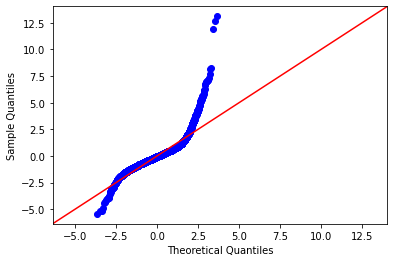

In [105]:
import scipy.stats as stats

preds = linreg.predict(X_test)

residuals = (y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

### Normality Assumption Met
* Removing the outlier values did not improve the predictive capacity of this model.

## Investigating Multicollinearity (independence assumption)

In [106]:
# estimate multicollinarity with Variance Inflation Factor (VIF)
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
pd.Series(vif, index=X_train.columns, name="Variance Inflation Factor")

sqft_living            20.769727
bathrooms              25.873608
bedrooms               21.707997
yr_built               26.166791
floors                 13.346781
water_1.0               1.539855
view_EXCELLENT          1.575620
view_FAIR               1.030293
view_GOOD               1.065173
condition_Fair          1.033324
condition_Good          1.541114
condition_Very Good     1.163142
grade_11 Excellent      1.299034
grade_12 Luxury         1.163570
grade_13 Mansion        1.036425
grade_4 Low             1.013306
grade_5 Fair            1.049837
grade_6 Low Average     1.338563
grade_8 Good            1.776729
grade_9 Better          1.575717
Name: Variance Inflation Factor, dtype: float64

### Assumption for Multicollinearity NOT met
* Many values over 5
    * sqft_living, bathrooms, bedrooms, yr_built, floors

## Investigating Homoscedasticity

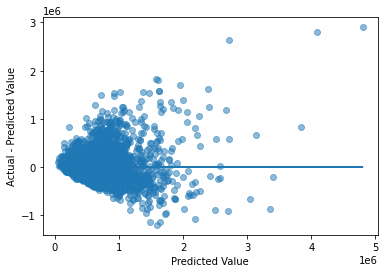

In [107]:
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

### Homoscedasticity assumption is NOT met
* This is a funnel shape and classic definition of poorly distributed data.

## Linear Regression Assumptions Fifth Model
* Linear Regression Assumptions not met on any category

# Feature Engineering 
* Improve predictive capacity of the model by removing outliers from numerical data.
* Test correlation of Products of Features

## Remove Outliers

In [108]:
remove_outliers = fourth_model

remove_outliers.describe()

,sqft_living_log,bathrooms_log,bedrooms_log,price_log,water_1.0,view_EXCELLENT,view_FAIR,view_GOOD,condition_Fair,condition_Good,...,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_8 Good,grade_9 Better,yr_built_log,floors_log
count,2.159700e+04,2.159700e+04,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,...,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,2.159700e+04,2.159700e+04
mean,-1.518667e-15,-9.475219e-17,-1.026482e-16,1.342323e-15,0.006760,0.014678,0.015280,0.023522,0.007871,0.262861,...,0.018475,0.004121,0.000602,0.001250,0.011205,0.094365,0.280826,0.121082,-2.568837e-15,2.105604e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.081944,0.120263,0.122667,0.151557,0.088373,0.440198,...,0.134664,0.064064,0.024528,0.035337,0.105263,0.292343,0.449413,0.326230,1.000000e+00,1.000000e+00
min,-3.859623e+00,-3.492572e+00,-4.159448e+00,-3.387580e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.445050e+00,-9.608519e-01
25%,-6.725525e-01,-3.006689e-01,-2.797180e-01,-6.949022e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.743255e-01,-9.608519e-01
50%,9.755245e-03,3.396529e-01,-2.797180e-01,-5.926843e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.430005e-01,1.901686e-01
75%,6.910288e-01,6.081000e-01,7.362261e-01,6.244262e-01,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,8.835377e-01,1.006831e+00
max,4.626885e+00,3.571681e+00,8.188407e+00,5.333765e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.483389e+00,2.595449e+00


In [109]:
remove_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sqft_living_log      21597 non-null  float64
 1   bathrooms_log        21597 non-null  float64
 2   bedrooms_log         21597 non-null  float64
 3   price_log            21597 non-null  float64
 4   water_1.0            21597 non-null  uint8  
 5   view_EXCELLENT       21597 non-null  uint8  
 6   view_FAIR            21597 non-null  uint8  
 7   view_GOOD            21597 non-null  uint8  
 8   condition_Fair       21597 non-null  uint8  
 9   condition_Good       21597 non-null  uint8  
 10  condition_Very Good  21597 non-null  uint8  
 11  grade_11 Excellent   21597 non-null  uint8  
 12  grade_12 Luxury      21597 non-null  uint8  
 13  grade_13 Mansion     21597 non-null  uint8  
 14  grade_4 Low          21597 non-null  uint8  
 15  grade_5 Fair         21597 non-null 

<AxesSubplot:>

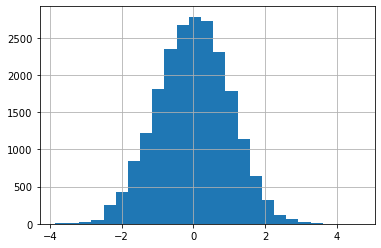

In [110]:
remove_outliers['sqft_living_log'].hist(bins=25)

In [111]:
# find cut-off for data outside 3 standard deviations (99.7% of data)
remove_outliers.quantile(q=.9985)

sqft_living_log        3.025420
bathrooms_log          2.498475
bedrooms_log           2.712499
price_log              3.666191
water_1.0              1.000000
view_EXCELLENT         1.000000
view_FAIR              1.000000
view_GOOD              1.000000
condition_Fair         1.000000
condition_Good         1.000000
condition_Very Good    1.000000
grade_11 Excellent     1.000000
grade_12 Luxury        1.000000
grade_13 Mansion       0.000000
grade_4 Low            0.000000
grade_5 Fair           1.000000
grade_6 Low Average    1.000000
grade_8 Good           1.000000
grade_9 Better         1.000000
yr_built_log           1.483389
floors_log             2.157851
Name: 0.9985, dtype: float64

In [112]:
# find cut-off for data outside 3 standard deviations (99.7% of data)
remove_outliers.quantile(q=.0015)

sqft_living_log       -2.882625
bathrooms_log         -2.459491
bedrooms_log          -4.159448
price_log             -2.823059
water_1.0              0.000000
view_EXCELLENT         0.000000
view_FAIR              0.000000
view_GOOD              0.000000
condition_Fair         0.000000
condition_Good         0.000000
condition_Very Good    0.000000
grade_11 Excellent     0.000000
grade_12 Luxury        0.000000
grade_13 Mansion       0.000000
grade_4 Low            0.000000
grade_5 Fair           0.000000
grade_6 Low Average    0.000000
grade_8 Good           0.000000
grade_9 Better         0.000000
yr_built_log          -2.445050
floors_log            -0.960852
Name: 0.0015, dtype: float64

<AxesSubplot:>

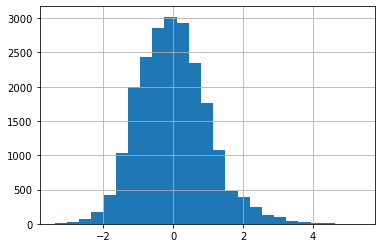

In [113]:
remove_outliers['price_log'].hist(bins=25)

In [114]:
# correlation before removing outliers
remove_outliers.corr()['price_log']['sqft_living_log']

0.674801656673277

In [115]:
remove_outliers = remove_outliers[(remove_outliers['price_log'] > -2.823) & (
    remove_outliers['price_log'] < 2.8)]

In [116]:
# correlation after removing outliers
remove_outliers.corr()['price_log']['sqft_living_log']

0.6527700673276549

In [117]:
remove_out_new.info()

NameError: name 'remove_out_new' is not defined

In [ ]:
remove_outliers.tail()

In [118]:
# Run model summary with only sqft_living_log

# Model Summary
X_ro = remove_outliers.drop(['price_log'], axis=1)
y_ro = remove_outliers['price_log']

X_int = sm.add_constant(X_ro)
model = sm.OLS(y_ro,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     1348.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:20:45   Log-Likelihood:                -20352.
No. Observations:               21366   AIC:                         4.075e+04
Df Residuals:                   21345   BIC:                         4.091e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1415      0.007    -19.149      0.000      -0.156      -0.127
sqft_living_log         0.5107      0.008     62.453      0.000       0.495       0.527
bathrooms_log           0.0986      0.008     12.693      0.000       0.083       0.114
bedrooms_log           -0.1290      0.006    -22.228      0.000      -0.140      -0.118
water_1.0               0.4210      0.073      5.777      0.000       0.278       0.564
view_EXCELLENT          0.6074      0.047     12.968      0.000       0.516       0.699
view_FAIR               0.3369      0.036      9.425      0.000       0.267       0.407
view_GOOD               0.3429      0.029     11.640      0.000       0.285       0.401
condition_Fair         -0.2952      0.050     -5.914      0.000      -0.393      -0.197
condition_Good          0.0060      0.011      0.558      0.577      -0.015       0.027
condition_Very Good     0.1270      0.017      7.354      0.000       0.093       0.161
grade_11 Excellent      0.9938      0.037     26.537      0.000       0.920       1.067
grade_12 Luxury         1.1885      0.086     13.891      0.000       1.021       1.356
grade_13 Mansion        1.7332      0.628      2.761      0.006       0.503       2.964
grade_4 Low            -0.3798      0.132     -2.878      0.004      -0.639      -0.121
grade_5 Fair           -0.5978      0.043    -13.902      0.000      -0.682      -0.513
grade_6 Low Average    -0.3810      0.017    -22.683      0.000      -0.414      -0.348
grade_8 Good            0.1910      0.011     17.552      0.000       0.170       0.212
grade_9 Better          0.5325      0.016     33.945      0.000       0.502       0.563
yr_built_log           -0.2879      0.006    -49.639      0.000      -0.299      -0.277
floors_log              0.1139      0.005     21.121      0.000       0.103       0.124
==============================================================================
Omnibus:                       15.060   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.167
Skew:                           0.034   Prob(JB):                     0.000309
Kurtosis:                       3.117   Cond. No.                         248.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## (skip) Remove all rows containing value outside 3 standard deviations
* Chose not to use this method because it dropped ~5% of data
    * This dropped values outside 3 std. dev. in every column.

In [119]:
# remove rows with values in any column outside
# 3 standard deviations.
remove_all_out = fourth_model

z_scores = stats.zscore(remove_all_out)

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1, keepdims=True)
new_df = remove_all_out[filtered_entries]

new_df.shape

(16331, 21)

### Considering this removes data, I will use it on the final model to check if it is worth performing to reduce heteroscedasticity and increase normality.
* I may not remove outliers, because it is reducing the predictive capacity of the model.

In [120]:
# did the quantiles change? -Yes
print('Old df:', remove_outliers.quantile(q=.995))
print()
print('New df:', new_df.quantile(q=.995))

Old df: sqft_living_log        2.361766
bathrooms_log          2.105716
bedrooms_log           2.168119
price_log              2.564766
water_1.0              0.000000
view_EXCELLENT         1.000000
view_FAIR              1.000000
view_GOOD              1.000000
condition_Fair         1.000000
condition_Good         1.000000
condition_Very Good    1.000000
grade_11 Excellent     1.000000
grade_12 Luxury        0.000000
grade_13 Mansion       0.000000
grade_4 Low            0.000000
grade_5 Fair           1.000000
grade_6 Low Average    1.000000
grade_8 Good           1.000000
grade_9 Better         1.000000
yr_built_log           1.450205
floors_log             2.157851
Name: 0.995, dtype: float64

New df: sqft_living_log        2.051121
bathrooms_log          1.960083
bedrooms_log           2.168119
price_log              2.373401
water_1.0              0.000000
view_EXCELLENT         0.000000
view_FAIR              0.000000
view_GOOD              0.000000
condition_Fair         0.00

In [121]:
# correlation after removing outliers.  Correlation decreased.
print('Sqft to Price - R^2 before removing outliers:',remove_outliers.corr()['price_log']['sqft_living_log'])
print('Sqft to Price - R^2 after removing outliers:',new_df.corr()['price_log']['sqft_living_log'])
print()
print('Sqft to Bathrooms - R^2 before removing outliers:',remove_outliers.corr()['price_log']['bathrooms_log'])
print('Sqft to Bathrooms - R^2 after removing outliers:',new_df.corr()['price_log']['bathrooms_log'])
print()
print('Sqft to Bedrooms - R^2 before removing outliers:',remove_outliers.corr()['price_log']['bedrooms_log'])
print('Sqft to Bedrooms - R^2 after removing outliers:',new_df.corr()['price_log']['bedrooms_log'])

Sqft to Price - R^2 before removing outliers: 0.6527700673276549
Sqft to Price - R^2 after removing outliers: 0.5747410264960593

Sqft to Bathrooms - R^2 before removing outliers: 0.4994216572943184
Sqft to Bathrooms - R^2 after removing outliers: 0.3796802793416962

Sqft to Bedrooms - R^2 before removing outliers: 0.3281513288189854
Sqft to Bedrooms - R^2 after removing outliers: 0.2546465981749395


### Dropping Outliers reduces correlation values.
* How does it impact normality and heteroscedasticity?

## (skip) Replace Outliers
* Chose to remove rather than replace outliers to retain actual data rather than create altered data.

In [122]:
replace_out = pd.concat([first_model, features_add], axis=1)

replace_out.head()

,sqft_living_log,bathrooms_log,bedrooms_log,price_log,yr_built_log,floors_log
0,-1.125556,-1.726509,-0.279718,-1.401998,-0.537409,-0.960852
1,0.709446,0.339653,-0.279718,0.279938,-0.674325,1.006831
2,-2.131893,-1.726509,-1.711611,-1.799430,-1.293945,-0.960852
3,0.070674,1.072635,0.736226,0.499698,-0.196338,-0.960852
4,-0.292725,0.039555,-0.279718,0.178434,0.547946,-0.960852


In [123]:
# find cut-off for data outside 3 standard deviations (99.7% of data)
print('lower quantile:',replace_out.quantile(q=.0015))
print()
print('upper quantile:',replace_out.quantile(q=.9985))


lower quantile: sqft_living_log   -2.882625
bathrooms_log     -2.459491
bedrooms_log      -4.159448
price_log         -2.823059
yr_built_log      -2.445050
floors_log        -0.960852
Name: 0.0015, dtype: float64

upper quantile: sqft_living_log    3.025420
bathrooms_log      2.498475
bedrooms_log       2.712499
price_log          3.666191
yr_built_log       1.483389
floors_log         2.157851
Name: 0.9985, dtype: float64


In [124]:
# https://stackoverflow.com/questions/45386955/python-replacing-outliers-values-with-median-values
# http://localhost:8888/notebooks/t20/ds-feature_selection_and_feature_engineering-nbz32/feature_selection_and_feature_engineering.ipynb

median = replace_out['sqft_living_log'].median()

# replace lower threshold of sqft_living_log
replace_out["sqft_living_log"] = np.where(
    replace_out["sqft_living_log"] > -2.883, median,replace_out['sqft_living_log'])

# replace upper threshold of sqft_living_log
replace_out["sqft_living_log"] = np.where(
    replace_out["sqft_living_log"] < 3.025, median,replace_out['sqft_living_log'])


In [125]:
# find cut-off for data outside 3 standard deviations (99.7% of data)

print('lower quantile:',replace_out.quantile(q=.0015))
print()
print('upper quantile:',replace_out.quantile(q=.9985))


lower quantile: sqft_living_log    0.009755
bathrooms_log     -2.459491
bedrooms_log      -4.159448
price_log         -2.823059
yr_built_log      -2.445050
floors_log        -0.960852
Name: 0.0015, dtype: float64

upper quantile: sqft_living_log    0.009755
bathrooms_log      2.498475
bedrooms_log       2.712499
price_log          3.666191
yr_built_log       1.483389
floors_log         2.157851
Name: 0.9985, dtype: float64


In [126]:
# correlation after replacing outliers with mean
replace_out.corr()['price_log']['sqft_living_log']

-8.096569752015661e-17

## Product features
* Experimenting with 
* What would correlation be for product of bedrooms and bathrooms with price?

In [127]:
# product of bedrooms and bathrooms
product_features = remove_outliers

# multiply bedrooms * bathrooms and add to new column in product features
product_features['bd*ba'
                ] = remove_outliers['bedrooms_log'
                ] * remove_outliers['bathrooms_log']

# save column in product_features data frame
product_features['bd*ba'] = product_features

# check product_features data frame
product_features.head()

<ipython-input-127-ca507c632347>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_features['bd*ba'
<ipython-input-127-ca507c632347>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_features['bd*ba'] = product_features


,sqft_living_log,bathrooms_log,bedrooms_log,price_log,water_1.0,view_EXCELLENT,view_FAIR,view_GOOD,condition_Fair,condition_Good,...,grade_12 Luxury,grade_13 Mansion,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_8 Good,grade_9 Better,yr_built_log,floors_log,bd*ba
0,-1.125556,-1.726509,-0.279718,-1.401998,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.537409,-0.960852,-1.125556
1,0.709446,0.339653,-0.279718,0.279938,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.674325,1.006831,0.709446
2,-2.131893,-1.726509,-1.711611,-1.799430,0,0,0,0,0,0,...,0,0,0,0,1,0,0,-1.293945,-0.960852,-2.131893
3,0.070674,1.072635,0.736226,0.499698,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.196338,-0.960852,0.070674
4,-0.292725,0.039555,-0.279718,0.178434,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0.547946,-0.960852,-0.292725


In [128]:
# Correlation value for product of bedrooms and bathrooms with price
product_features.corr()['price_log']['bd*ba']

0.6527700673276549

In [129]:
# R-squared for bedrooms and price
product_features.corr()['price_log']['bedrooms_log']

0.3281513288189854

In [130]:
# R-squared for bathrooms and price
product_features.corr()['price_log']['bathrooms_log']

0.4994216572943184

### Product of bedrooms and bathrooms increases correlation.
* Correlation between bedrooms and bathrooms incresed when using product of bed*bath.
* Maybe this feature should be included in a strictly predictive model.
* I will probably not include it in my final model as I am recommending which features are more important and it is not advisable to interpret the importance of features separately from a product coefficient.
    * Though, it may be worth noting that adding a bedroom and bathroom together are much more likely to increase price than adding only a bedroom or a bathroom.

## Account for Interactions
* Products of features with interactions will not be included in the final model to improve the accuracy of interpreting the coefficients.
* If a model was needed for strictly predictive purposes, then the products of features with interactions would be included.

### Find top interactions using itertools.

In [131]:
linreg = LinearRegression()

# re-define fourth model
X_inter = fourth_model.drop('price_log', axis=1)
y_inter = fourth_model['price_log']

# define crossvalidation and baseline
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(linreg, X_inter, y_inter, scoring='r2', cv=crossvalidation))

interactions = []

feat_combinations = combinations(X_inter.columns, 2)

# loop for all combinations of 2 predictors
data = X_inter.copy()
for i, (a, b) in enumerate(feat_combinations):
    data['interaction'] = data[a] * data[b]
    score = np.mean(cross_val_score(linreg, data, y_inter, scoring='r2', cv=crossvalidation))
    if score > baseline:
        interactions.append((a, b, round(score,3)))
    
    if i % 50 == 0:
        print(i)
            
print('Top 5 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:5])

0
50
100
150
Top 5 interactions: [('sqft_living_log', 'bathrooms_log', 0.605), ('sqft_living_log', 'bedrooms_log', 0.598), ('bathrooms_log', 'yr_built_log', 0.596), ('sqft_living_log', 'grade_8 Good', 0.595), ('sqft_living_log', 'yr_built_log', 0.595)]


In [132]:
# define crossvalidation again and create interactions_df
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
interactions_df = X_inter.copy()

# add columns for product features to interactions_df
interactions_df['sqft_living*bathrooms'] = interactions_df[
    'sqft_living_log'] * interactions_df['bathrooms_log']

interactions_df['sqft_living*bedrooms'] = interactions_df[
    'sqft_living_log'] * interactions_df['bedrooms_log']

interactions_df['sqft_living*yr_built'] = interactions_df[
    'sqft_living_log'] * interactions_df['yr_built_log']

interactions_df['bedrooms*bathrooms'] = interactions_df[
    'bedrooms_log'] * interactions_df['bathrooms_log']

# Attain R-squared value for fourth model and interactions_df with added product features
fourth_score = np.mean(cross_val_score(linreg, X_ro, y_ro, scoring='r2', cv=crossvalidation))
inter_score = np.mean(cross_val_score(linreg, interactions_df, y_inter, scoring='r2', cv=crossvalidation))

# print R-squared value for fourth model and added interactions_df
print('Fourth Model Score:',fourth_score)
print('Added interactions Score:',inter_score)

Fourth Model Score: 0.5567837209147528
Added interactions Score: 0.6070981193225652


In [133]:
# Check that columns were added for product features
interactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sqft_living_log        21597 non-null  float64
 1   bathrooms_log          21597 non-null  float64
 2   bedrooms_log           21597 non-null  float64
 3   water_1.0              21597 non-null  uint8  
 4   view_EXCELLENT         21597 non-null  uint8  
 5   view_FAIR              21597 non-null  uint8  
 6   view_GOOD              21597 non-null  uint8  
 7   condition_Fair         21597 non-null  uint8  
 8   condition_Good         21597 non-null  uint8  
 9   condition_Very Good    21597 non-null  uint8  
 10  grade_11 Excellent     21597 non-null  uint8  
 11  grade_12 Luxury        21597 non-null  uint8  
 12  grade_13 Mansion       21597 non-null  uint8  
 13  grade_4 Low            21597 non-null  uint8  
 14  grade_5 Fair           21597 non-null  uint8  
 15  gr

### Increased R-squared with Product Features
* Product features did increase the R-squared value, so adding the interactions does increase the likelihood that the model predicts price.
    * However, accurate price prediction is only part of the goal, and the main goal is to provide inference about the price change correlated to individual features, so the product features will be left out of the model.

# Interpret the Final Model
* The Fourth Model after price outliers were dropped is the final model as it met the assumptions for linearity and it provides relevant inferential information, if not an actual change in price.

In [134]:
final_model = remove_outliers.drop(['bd*ba'], axis=1)

X_final = final_model.drop(['price_log'], axis=1)
y_final = final_model['price_log']

In [135]:
print('Final Check of X data frame:')
print()
print(X_final.info())
print()
print('Final Check of y array:')
print()
print(y_final.describe())

Final Check of X data frame:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21366 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sqft_living_log      21366 non-null  float64
 1   bathrooms_log        21366 non-null  float64
 2   bedrooms_log         21366 non-null  float64
 3   water_1.0            21366 non-null  uint8  
 4   view_EXCELLENT       21366 non-null  uint8  
 5   view_FAIR            21366 non-null  uint8  
 6   view_GOOD            21366 non-null  uint8  
 7   condition_Fair       21366 non-null  uint8  
 8   condition_Good       21366 non-null  uint8  
 9   condition_Very Good  21366 non-null  uint8  
 10  grade_11 Excellent   21366 non-null  uint8  
 11  grade_12 Luxury      21366 non-null  uint8  
 12  grade_13 Mansion     21366 non-null  uint8  
 13  grade_4 Low          21366 non-null  uint8  
 14  grade_5 Fair         21366 non-null  uint8  
 15  grade_

## Model Summary
* Summary of final model - also part of Section 12: Interpretting Coefficients

In [136]:
X_final 
y_final

X_int = sm.add_constant(X_final)
model = sm.OLS(y_final,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     1348.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:21:52   Log-Likelihood:                -20352.
No. Observations:               21366   AIC:                         4.075e+04
Df Residuals:                   21345   BIC:                         4.091e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1415      0.007    -19.149      0.000      -0.156      -0.127
sqft_living_log         0.5107      0.008     62.453      0.000       0.495       0.527
bathrooms_log           0.0986      0.008     12.693      0.000       0.083       0.114
bedrooms_log           -0.1290      0.006    -22.228      0.000      -0.140      -0.118
water_1.0               0.4210      0.073      5.777      0.000       0.278       0.564
view_EXCELLENT          0.6074      0.047     12.968      0.000       0.516       0.699
view_FAIR               0.3369      0.036      9.425      0.000       0.267       0.407
view_GOOD               0.3429      0.029     11.640      0.000       0.285       0.401
condition_Fair         -0.2952      0.050     -5.914      0.000      -0.393      -0.197
condition_Good          0.0060      0.011      0.558      0.577      -0.015       0.027
condition_Very Good     0.1270      0.017      7.354      0.000       0.093       0.161
grade_11 Excellent      0.9938      0.037     26.537      0.000       0.920       1.067
grade_12 Luxury         1.1885      0.086     13.891      0.000       1.021       1.356
grade_13 Mansion        1.7332      0.628      2.761      0.006       0.503       2.964
grade_4 Low            -0.3798      0.132     -2.878      0.004      -0.639      -0.121
grade_5 Fair           -0.5978      0.043    -13.902      0.000      -0.682      -0.513
grade_6 Low Average    -0.3810      0.017    -22.683      0.000      -0.414      -0.348
grade_8 Good            0.1910      0.011     17.552      0.000       0.170       0.212
grade_9 Better          0.5325      0.016     33.945      0.000       0.502       0.563
yr_built_log           -0.2879      0.006    -49.639      0.000      -0.299      -0.277
floors_log              0.1139      0.005     21.121      0.000       0.103       0.124
==============================================================================
Omnibus:                       15.060   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.167
Skew:                           0.034   Prob(JB):                     0.000309
Kurtosis:                       3.117   Cond. No.                         248.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [137]:
X_final = final_model.drop('price_log', axis=1)
y_final = final_model['price_log']

In [138]:
# Split the data into training and test sets. Use the default split size

X_train, X_test, y_train, y_test = train_test_split(X_final,y_final, test_size=.4)

# A brief preview of tts
print(len(X_train), len(X_test), len(y_train), len(y_test))

12819 8547 12819 8547


In [139]:
linreg = LinearRegression()

# Fit the model to train data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression()

In [140]:
# Calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [141]:
# Calculate residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [142]:
# Calculate training and test MSE
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 0.3948073775823509
Test Mean Squared Error: 0.3921055916716476


### Instantiate a Linear Regression model called final_model, then fit it to training data and score it on test data.

In [143]:
linreg = LinearRegression()

# Fit the model on X_train_final and y_train
linreg.fit(X_train, y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
linreg.score(X_test, y_test)

0.564106721858775

## Investigating Normality

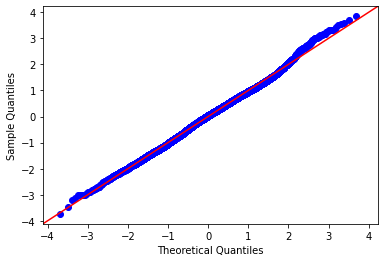

In [144]:
import scipy.stats as stats

preds = linreg.predict(X_test)

residuals = (y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

### Normality Assumption Met
* Removing the outlier values improved the normality of this model.
* 0.838% or less than 1% of data was removed to improve the normality assumption.

## Investigating Multicollinearity (independence assumption)

In [145]:
# estimate multicollinarity with Variance Inflation Factor (VIF)
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
pd.Series(vif, index=X_train.columns, name="Variance Inflation Factor")

sqft_living_log        3.410109
bathrooms_log          3.169271
bedrooms_log           1.782908
water_1.0              1.424795
view_EXCELLENT         1.456145
view_FAIR              1.024036
view_GOOD              1.067771
condition_Fair         1.025847
condition_Good         1.316292
condition_Very Good    1.159589
grade_11 Excellent     1.127426
grade_12 Luxury        1.033292
grade_13 Mansion       1.000863
grade_4 Low            1.010690
grade_5 Fair           1.077829
grade_6 Low Average    1.357208
grade_8 Good           1.272039
grade_9 Better         1.317271
yr_built_log           1.783002
floors_log             1.586231
Name: Variance Inflation Factor, dtype: float64

### Removed predictors with score greater than 5
* view_NONE (12.4)
* grade_7 Average (7.42)

## Investigating Homoscedasticity

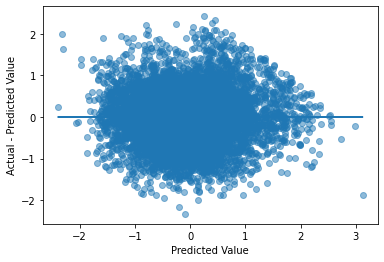

In [146]:
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

### Homoscedasticity assumption is met
* Removing a few outliers did slightly improve the distribution.   

# Alternative Models

## Fifth and non-normal NOT final Model
* Provides values that can be used to predict price, but not compared well to one another.

In [147]:
# Comparing to Fourth Model Summary
X5 = fifth_model.drop(['price'], axis=1)
y5 = fifth_model['price']

X_int = sm.add_constant(X5)
model = sm.OLS(y5,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     1935.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:21:54   Log-Likelihood:            -2.9630e+05
No. Observations:               21597   AIC:                         5.926e+05
Df Residuals:                   21576   BIC:                         5.928e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 6.09e+06   1.33e+05     45.817      0.000    5.83e+06    6.35e+06
sqft_living           211.4594      3.018     70.066      0.000     205.544     217.375
bathrooms            5.557e+04   3512.546     15.821      0.000    4.87e+04    6.25e+04
bedrooms             -4.22e+04   2071.209    -20.374      0.000   -4.63e+04   -3.81e+04
yr_built            -3088.8167     68.299    -45.225      0.000   -3222.687   -2954.946
floors               5.644e+04   3495.164     16.148      0.000    4.96e+04    6.33e+04
water_1.0             5.14e+05   2.23e+04     23.072      0.000     4.7e+05    5.58e+05
view_EXCELLENT       2.892e+05   1.54e+04     18.801      0.000    2.59e+05    3.19e+05
view_FAIR            1.261e+05   1.23e+04     10.265      0.000    1.02e+05     1.5e+05
view_GOOD            1.308e+05   1.01e+04     12.947      0.000    1.11e+05    1.51e+05
condition_Fair      -3.817e+04   1.71e+04     -2.226      0.026   -7.18e+04   -4561.612
condition_Good       1.042e+04   3714.662      2.804      0.005    3135.982    1.77e+04
condition_Very Good  4.836e+04   5991.101      8.073      0.000    3.66e+04    6.01e+04
grade_11 Excellent   4.297e+05   1.26e+04     34.137      0.000    4.05e+05    4.54e+05
grade_12 Luxury      8.079e+05   2.49e+04     32.485      0.000    7.59e+05    8.57e+05
grade_13 Mansion     1.866e+06   6.24e+04     29.895      0.000    1.74e+06    1.99e+06
grade_4 Low         -9.048e+04   4.26e+04     -2.124      0.034   -1.74e+05   -6982.078
grade_5 Fair        -1.165e+05   1.46e+04     -7.992      0.000   -1.45e+05   -8.79e+04
grade_6 Low Average -7.276e+04   5728.203    -12.702      0.000    -8.4e+04   -6.15e+04
grade_8 Good         1.326e+04   3765.672      3.521      0.000    5879.082    2.06e+04
grade_9 Better           1e+05   5428.994     18.422      0.000    8.94e+04    1.11e+05
==============================================================================
Omnibus:                    10877.567   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           254020.268
Skew:                           1.914   Prob(JB):                         0.00
Kurtosis:                      19.359   Cond. No.                     2.62e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.62e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Logged Values Model

### Create logged_df from prior logged data frames and ohe predictors

In [148]:
# check house_log df
house_log.head()

,sqft_living_log,bathrooms_log,bedrooms_log,price_log
0,7.073270,0.000000,1.098612,12.309982
1,7.851661,0.810930,1.098612,13.195614
2,6.646391,0.000000,0.693147,12.100712
3,7.580700,1.098612,1.386294,13.311329
4,7.426549,0.693147,1.098612,13.142166


In [149]:
# check house_log2 df
house_log2.head()

,yr_built_log,floors_log
0,7.578145,0.000000
1,7.576097,0.693147
2,7.566828,0.000000
3,7.583248,0.000000
4,7.594381,0.000000


In [150]:
# check ohe_only df
ohe_only.head()

,water_1.0,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE,condition_Fair,condition_Good,condition_Poor,condition_Very Good,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_3 Poor,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [151]:
# create logged df with categorical features
logged_df = pd.concat([house_log,
                      house_log2,
                      ohe_only], axis=1)

logged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sqft_living_log      21597 non-null  float64
 1   bathrooms_log        21597 non-null  float64
 2   bedrooms_log         21597 non-null  float64
 3   price_log            21597 non-null  float64
 4   yr_built_log         21597 non-null  float64
 5   floors_log           21597 non-null  float64
 6   water_1.0            21597 non-null  uint8  
 7   view_EXCELLENT       21597 non-null  uint8  
 8   view_FAIR            21597 non-null  uint8  
 9   view_GOOD            21597 non-null  uint8  
 10  view_NONE            21597 non-null  uint8  
 11  condition_Fair       21597 non-null  uint8  
 12  condition_Good       21597 non-null  uint8  
 13  condition_Poor       21597 non-null  uint8  
 14  condition_Very Good  21597 non-null  uint8  
 15  grade_11 Excellent   21597 non-null 

### Drop columns

In [152]:
# Remove columns with prior issues (p-values & multicollinearity)
# condition_Good also dropped due to high p-value afer running summary

logged_df = logged_df.drop(['condition_Good',
                            'view_NONE',
                            'grade_7 Average',
                            'condition_Poor',
                            'grade_3 Poor',], axis=1)

logged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sqft_living_log      21597 non-null  float64
 1   bathrooms_log        21597 non-null  float64
 2   bedrooms_log         21597 non-null  float64
 3   price_log            21597 non-null  float64
 4   yr_built_log         21597 non-null  float64
 5   floors_log           21597 non-null  float64
 6   water_1.0            21597 non-null  uint8  
 7   view_EXCELLENT       21597 non-null  uint8  
 8   view_FAIR            21597 non-null  uint8  
 9   view_GOOD            21597 non-null  uint8  
 10  condition_Fair       21597 non-null  uint8  
 11  condition_Very Good  21597 non-null  uint8  
 12  grade_11 Excellent   21597 non-null  uint8  
 13  grade_12 Luxury      21597 non-null  uint8  
 14  grade_13 Mansion     21597 non-null  uint8  
 15  grade_4 Low          21597 non-null 

### Model Summary

In [153]:
# Logged Values Model Summary
X_log = logged_df.drop(['price_log'], axis=1)
y_log = logged_df['price_log']

X_int = sm.add_constant(X_log)
model = sm.OLS(y_log,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     1647.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:22:14   Log-Likelihood:                -7112.6
No. Observations:               21597   AIC:                         1.427e+04
Df Residuals:                   21577   BIC:                         1.442e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  86.5273      1.530     56.539      0.000      83.528      89.527
sqft_living_log         0.6561      0.010     63.966      0.000       0.636       0.676
bathrooms_log           0.1430      0.011     13.547      0.000       0.122       0.164
bedrooms_log           -0.2453      0.011    -22.457      0.000      -0.267      -0.224
yr_built_log          -10.3301      0.201    -51.446      0.000     -10.724      -9.937
floors_log              0.1695      0.008     21.128      0.000       0.154       0.185
water_1.0               0.3119      0.034      9.149      0.000       0.245       0.379
view_EXCELLENT          0.3434      0.024     14.606      0.000       0.297       0.390
view_FAIR               0.1918      0.019     10.200      0.000       0.155       0.229
view_GOOD               0.1885      0.015     12.221      0.000       0.158       0.219
condition_Fair         -0.1693      0.026     -6.475      0.000      -0.221      -0.118
condition_Very Good     0.0688      0.009      7.772      0.000       0.051       0.086
grade_11 Excellent      0.5771      0.019     31.136      0.000       0.541       0.613
grade_12 Luxury         0.7428      0.037     20.084      0.000       0.670       0.815
grade_13 Mansion        1.0076      0.094     10.707      0.000       0.823       1.192
grade_4 Low            -0.3133      0.065     -4.787      0.000      -0.442      -0.185
grade_5 Fair           -0.3472      0.023    -15.411      0.000      -0.391      -0.303
grade_6 Low Average    -0.2003      0.009    -22.311      0.000      -0.218      -0.183
grade_8 Good            0.0911      0.006     15.678      0.000       0.080       0.103
grade_9 Better          0.2674      0.008     32.008      0.000       0.251       0.284
==============================================================================
Omnibus:                       44.228   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.436
Skew:                           0.060   Prob(JB):                     1.12e-11
Kurtosis:                       3.204   Cond. No.                     7.31e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Train, Test, Split

In [154]:
# re-iterate X and y variables
X_log
y_log

0        12.309982
1        13.195614
2        12.100712
3        13.311329
4        13.142166
           ...    
21592    12.793859
21593    12.899220
21594    12.904459
21595    12.899220
21596    12.691580
Name: price_log, Length: 21597, dtype: float64

In [155]:
# Split the data into training and test sets. Use the default split size

X_train, X_test, y_train, y_test = train_test_split(X_log,y_log, test_size=.4)

# A brief preview of tts
print(len(X_train), len(X_test), len(y_train), len(y_test))

12958 8639 12958 8639


In [156]:
linreg = LinearRegression()

# Fit the model to train data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression()

In [157]:
# Calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [158]:
# Calculate residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [159]:
# Calculate training and test MSE
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 0.11251728134611115
Test Mean Squared Error: 0.11427819566403802


### Instantiate a Linear Regression model called final_model, then fit it to training data and score it on test data.

In [160]:
linreg = LinearRegression()

# Fit the model on X_train_final and y_train
linreg.fit(X_train, y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
linreg.score(X_test, y_test)

0.581736785449336

### Investigating Normality

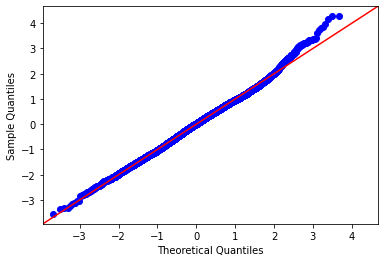

In [161]:
import scipy.stats as stats

preds = linreg.predict(X_test)

residuals = (y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

#### Normality Assumption Met
* Removing the outlier values improved the normality of this model.
* 0.838% or less than 1% of data was removed to improve the normality assumption.

### Investigating Multicollinearity (independence assumption)

In [162]:
# estimate multicollinarity with Variance Inflation Factor (VIF)
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
pd.Series(vif, index=X_train.columns, name="Variance Inflation Factor")

sqft_living_log        1132.781861
bathrooms_log            11.574298
bedrooms_log             33.404316
yr_built_log            887.768223
floors_log                2.817814
water_1.0                 1.492053
view_EXCELLENT            1.540941
view_FAIR                 1.024807
view_GOOD                 1.063507
condition_Fair            1.025373
condition_Very Good       1.106361
grade_11 Excellent        1.206691
grade_12 Luxury           1.072621
grade_13 Mansion          1.023092
grade_4 Low               1.020298
grade_5 Fair              1.077543
grade_6 Low Average       1.423754
grade_8 Good              1.799481
grade_9 Better            1.611785
Name: Variance Inflation Factor, dtype: float64

#### VIF scores very high for important predictors 
* sqft_living_log (1118.9)
* bathrooms_log (11.29)
* bedrooms_log (32.9)
* yr_built_log (881.4)

#### Multicollinearity Assumption NOT met for logged_df

### Investigating Homoscedasticity

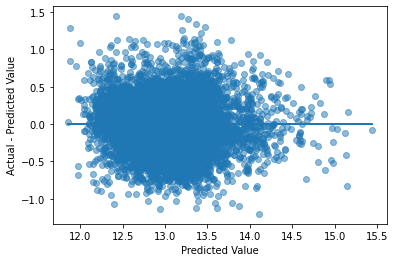

In [163]:
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

#### Homoscedasticity assumption is met
* Distribution is fairly even.  

# Interpretting Coefficients
* Final Model
* Logged Model
* Fifth Model
    * Un-normalized or logged feature values
* Converting Coefficients


## Final Model
* This is the same as the Fourth Model with the outliers removed.

In [164]:
# Final Model Summary
X_final 
y_final

X_int = sm.add_constant(X_final)
model = sm.OLS(y_final,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     1348.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:22:21   Log-Likelihood:                -20352.
No. Observations:               21366   AIC:                         4.075e+04
Df Residuals:                   21345   BIC:                         4.091e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1415      0.007    -19.149      0.000      -0.156      -0.127
sqft_living_log         0.5107      0.008     62.453      0.000       0.495       0.527
bathrooms_log           0.0986      0.008     12.693      0.000       0.083       0.114
bedrooms_log           -0.1290      0.006    -22.228      0.000      -0.140      -0.118
water_1.0               0.4210      0.073      5.777      0.000       0.278       0.564
view_EXCELLENT          0.6074      0.047     12.968      0.000       0.516       0.699
view_FAIR               0.3369      0.036      9.425      0.000       0.267       0.407
view_GOOD               0.3429      0.029     11.640      0.000       0.285       0.401
condition_Fair         -0.2952      0.050     -5.914      0.000      -0.393      -0.197
condition_Good          0.0060      0.011      0.558      0.577      -0.015       0.027
condition_Very Good     0.1270      0.017      7.354      0.000       0.093       0.161
grade_11 Excellent      0.9938      0.037     26.537      0.000       0.920       1.067
grade_12 Luxury         1.1885      0.086     13.891      0.000       1.021       1.356
grade_13 Mansion        1.7332      0.628      2.761      0.006       0.503       2.964
grade_4 Low            -0.3798      0.132     -2.878      0.004      -0.639      -0.121
grade_5 Fair           -0.5978      0.043    -13.902      0.000      -0.682      -0.513
grade_6 Low Average    -0.3810      0.017    -22.683      0.000      -0.414      -0.348
grade_8 Good            0.1910      0.011     17.552      0.000       0.170       0.212
grade_9 Better          0.5325      0.016     33.945      0.000       0.502       0.563
yr_built_log           -0.2879      0.006    -49.639      0.000      -0.299      -0.277
floors_log              0.1139      0.005     21.121      0.000       0.103       0.124
==============================================================================
Omnibus:                       15.060   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.167
Skew:                           0.034   Prob(JB):                     0.000309
Kurtosis:                       3.117   Cond. No.                         248.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [165]:
# information on raw data
# standard deviation of price
fifth_model.describe()

,price,sqft_living,bathrooms,bedrooms,yr_built,floors,water_1.0,view_EXCELLENT,view_FAIR,view_GOOD,...,condition_Good,condition_Very Good,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_8 Good,grade_9 Better
count,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,...,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,2080.321850,2.115826,3.373200,1970.999676,1.494096,0.006760,0.014678,0.015280,0.023522,...,0.262861,0.078761,0.018475,0.004121,0.000602,0.001250,0.011205,0.094365,0.280826,0.121082
std,3.673681e+05,918.106125,0.768984,0.926299,29.375234,0.539683,0.081944,0.120263,0.122667,0.151557,...,0.440198,0.269372,0.134664,0.064064,0.024528,0.035337,0.105263,0.292343,0.449413,0.326230
min,7.800000e+04,370.000000,0.500000,1.000000,1900.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.220000e+05,1430.000000,1.750000,3.000000,1951.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000e+05,1910.000000,2.250000,3.000000,1975.000000,1.500000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.450000e+05,2550.000000,2.500000,4.000000,1997.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,7.700000e+06,13540.000000,8.000000,33.000000,2015.000000,3.500000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Calculate Raw Increase
* Use Standard Deviation of Raw Values and Coefficient of Z-Score Standardized values to determine raw increase or decrease by Feature.
    * Calculations performed by hand due to difference in coefficient value being used, rather than coefficeint score, for View, Condition, and Grade.
    * [Source for recommendation of Z-Score Standardized Coefficient Interpretation.](https://stats.stackexchange.com/questions/407822/interpretation-of-standardized-z-score-rescaled-linear-model-coefficients)

#### Create data frame of scores

In [166]:
# initialize list of lists
data_coeff = [['Sqft Living: Add 900', 0.5107, 367368.1, 187614.89, 918.11],
              ['Bathrooms', 0.0986, 367368.1, 36222.49, 0.769],
              ['Bedrooms', -0.129, 367368.1, -47390.49, 0.926],
              ['Waterfront',0.4210, 367368.1, 154661.97, 1],
              ['View: Fair to Excellent',0.2705, 367368.1, 99373.07, 1],
              ['Condition: Fair to Very Good', 0.4222, 367368.1, 155102.81, 1],
              ['Grade: Good to Better', 0.3415, 367368.1, 126448.10, 1],
              ['Year Built', -0.2879, 367368.1, -107765.28, 29.375],
              ['Floors', 0.1193, 367368.1, 41843.23, .5397]]

# create pandas data frame
final_interp = pd.DataFrame(data_coeff, columns = ['Features',
                                                   'Coefficient', 
                                                   'std_of_Price',
                                                   'Price Change',
                                                   'std_of_Raw_Feature'])
final_interp

,Features,Coefficient,std_of_Price,Price Change,std_of_Raw_Feature
0,Sqft Living: Add 900,0.5107,367368.1,187614.89,918.1100
1,Bathrooms,0.0986,367368.1,36222.49,0.7690
2,Bedrooms,-0.1290,367368.1,-47390.49,0.9260
3,Waterfront,0.4210,367368.1,154661.97,1.0000
4,View: Fair to Excellent,0.2705,367368.1,99373.07,1.0000
5,Condition: Fair to Very Good,0.4222,367368.1,155102.81,1.0000
6,Grade: Good to Better,0.3415,367368.1,126448.10,1.0000
7,Year Built,-0.2879,367368.1,-107765.28,29.3750
8,Floors,0.1193,367368.1,41843.23,0.5397


### Plot Top Features

In [167]:
top_features = final_interp.loc[(
    final_interp['Features']=='Sqft Living: Add 900')|(
    final_interp['Features']=='Condition: Fair to Very Good')|(
    final_interp['Features']=='Grade: Good to Better')
    ]
top_features

,Features,Coefficient,std_of_Price,Price Change,std_of_Raw_Feature
0,Sqft Living: Add 900,0.5107,367368.1,187614.89,918.11
5,Condition: Fair to Very Good,0.4222,367368.1,155102.81,1.00
6,Grade: Good to Better,0.3415,367368.1,126448.10,1.00


Text(0.5, 1.0, 'House Price Increase by Feature')

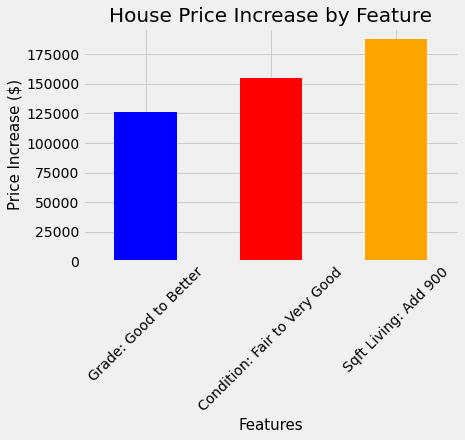

In [168]:
# Plot top Features
plt.style.use('fivethirtyeight')
top_features.sort_values('Price Change', ascending=True
                        ).plot.bar(x='Features',
                                   y='Price Change',
                                   rot=45,
                                   color=['blue','red','orange'],
                                   legend=False
                                    )
plt.xlabel("Features", fontsize=15)
plt.ylabel("Price Increase ($)", fontsize=15)
plt.title("House Price Increase by Feature", fontsize=20)

### Plot Secondary Features

In [169]:
# create data frame for secondary features
sec_features = final_interp.loc[(
    final_interp['Features']=='Floors')|(
    final_interp['Features']=='View: Fair to Excellent')|(
    final_interp['Features']=='Bathrooms')
    ]
sec_features

,Features,Coefficient,std_of_Price,Price Change,std_of_Raw_Feature
1,Bathrooms,0.0986,367368.1,36222.49,0.7690
4,View: Fair to Excellent,0.2705,367368.1,99373.07,1.0000
8,Floors,0.1193,367368.1,41843.23,0.5397


In [170]:
# modify feature price increase to be proportional to a whole unit
# instead of .5397 floors, now one floor's worth of price change
# will be incorporated into model

sec_feat_mod = sec_features

sec_feat_mod['mod_increase'] = sec_feat_mod['Price Change']/sec_feat_mod['std_of_Raw_Feature']

sec_feat_mod

<ipython-input-170-395e9b0c7f51>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sec_feat_mod['mod_increase'] = sec_feat_mod['Price Change']/sec_feat_mod['std_of_Raw_Feature']


,Features,Coefficient,std_of_Price,Price Change,std_of_Raw_Feature,mod_increase
1,Bathrooms,0.0986,367368.1,36222.49,0.7690,47103.368010
4,View: Fair to Excellent,0.2705,367368.1,99373.07,1.0000,99373.070000
8,Floors,0.1193,367368.1,41843.23,0.5397,77530.535483


Text(0.5, 1.0, 'House Price Increase by Feature')

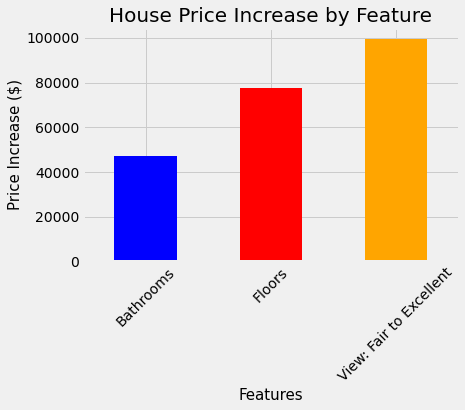

In [171]:
plt.style.use('fivethirtyeight')
sec_features.sort_values('Price Change', ascending=True
                        ).plot.bar(x='Features',
                                   y='mod_increase',
                                   rot=45,
                                   color=['blue','red','orange'],
                                   legend=False
                                    )
plt.xlabel("Features", fontsize=15)
plt.ylabel("Price Increase ($)", fontsize=15)
plt.title("House Price Increase by Feature", fontsize=20)

### Summary: Coefficient Interpretation
* The coefficient represents a 1 standard deviation increase in the response (dependent variable) for a given (coefficient * 1 std. dev. of predictor) increase in the predictor (independent variable).
* Multiply Standardized Feature Coefficient by 1 Standard Deviation of raw Price value..
* 1 Standard Deviation for raw Price = 367,368.10
* Feature Impact on Price
    * An increase of 918.11 square feet increased the price by 187,614.89
    * An increase of 0.769 bathrooms increased the price by 36,222.49
    * Increase of 0.926 bedrooms decreased the price by 47,390.48
    * Addition of waterfront increased price by 154,661.97
    * Changing view from Fair to Excellent, increased price by 99,373.07
    * Changing condition from Fair to Very Good, increased price by 155,102,81
    * Changing grade from grade8_good to grade9_better, increased price by 126,448.10
    * An increase of 29.38 years of age decreased the price by 105,765.28
    * An increase of .54 floors increased the price of a house by 41,843.23

* I will further simplify and approximate the values I use from this final model coefficent interpretation for a non-technical audience.

## Fifth Model

In [172]:
# Fifth Model Summary
X5 = fifth_model.drop(['price'], axis=1)
y5 = fifth_model['price']

X_int = sm.add_constant(X5)
model = sm.OLS(y5,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     1935.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:22:25   Log-Likelihood:            -2.9630e+05
No. Observations:               21597   AIC:                         5.926e+05
Df Residuals:                   21576   BIC:                         5.928e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 6.09e+06   1.33e+05     45.817      0.000    5.83e+06    6.35e+06
sqft_living           211.4594      3.018     70.066      0.000     205.544     217.375
bathrooms            5.557e+04   3512.546     15.821      0.000    4.87e+04    6.25e+04
bedrooms             -4.22e+04   2071.209    -20.374      0.000   -4.63e+04   -3.81e+04
yr_built            -3088.8167     68.299    -45.225      0.000   -3222.687   -2954.946
floors               5.644e+04   3495.164     16.148      0.000    4.96e+04    6.33e+04
water_1.0             5.14e+05   2.23e+04     23.072      0.000     4.7e+05    5.58e+05
view_EXCELLENT       2.892e+05   1.54e+04     18.801      0.000    2.59e+05    3.19e+05
view_FAIR            1.261e+05   1.23e+04     10.265      0.000    1.02e+05     1.5e+05
view_GOOD            1.308e+05   1.01e+04     12.947      0.000    1.11e+05    1.51e+05
condition_Fair      -3.817e+04   1.71e+04     -2.226      0.026   -7.18e+04   -4561.612
condition_Good       1.042e+04   3714.662      2.804      0.005    3135.982    1.77e+04
condition_Very Good  4.836e+04   5991.101      8.073      0.000    3.66e+04    6.01e+04
grade_11 Excellent   4.297e+05   1.26e+04     34.137      0.000    4.05e+05    4.54e+05
grade_12 Luxury      8.079e+05   2.49e+04     32.485      0.000    7.59e+05    8.57e+05
grade_13 Mansion     1.866e+06   6.24e+04     29.895      0.000    1.74e+06    1.99e+06
grade_4 Low         -9.048e+04   4.26e+04     -2.124      0.034   -1.74e+05   -6982.078
grade_5 Fair        -1.165e+05   1.46e+04     -7.992      0.000   -1.45e+05   -8.79e+04
grade_6 Low Average -7.276e+04   5728.203    -12.702      0.000    -8.4e+04   -6.15e+04
grade_8 Good         1.326e+04   3765.672      3.521      0.000    5879.082    2.06e+04
grade_9 Better           1e+05   5428.994     18.422      0.000    8.94e+04    1.11e+05
==============================================================================
Omnibus:                    10877.567   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           254020.268
Skew:                           1.914   Prob(JB):                         0.00
Kurtosis:                      19.359   Cond. No.                     2.62e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.62e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Dollar value changes for predictors in Fifth model.
* These values will not be used in the presentation, as this model did not fit the assumptions of linearity, but they are helpful as a means of comparison to help ensure the interpretation of the z-score standardized final_model coefficients are correct.

***
* For every increase in 1 square foot, the price increases by 211.46 dollars
    * This is an increase of 105,730.00 dollars for every 500 square feet.
* For every additional bedroom, the price decreases by 42,200 dollars.
    * This is an issue in our model because homes with fewer bedrooms are likely to cost more than homes with more bedrooms - likely conflated by other variables such as location.
* For each additional bathroom, the price of a home increses by 55,570 dollars.
* For every year a house becomes older, it decreases in value by 3,088.82 dollars.
* Each additional floor increases the value of a home by 56,440.00.

## Inverse of Standardization of Coefficients

In [173]:
# form data frame with coefficients

lr = LinearRegression()
lr.fit(X_final, y_final)

orig_coefs = lr.coef_

coefs1 = pd.DataFrame(
    data={
        'feature': final_model.drop(['price_log'], axis=1).columns, 
        'orig_coef' : orig_coefs, 
    }
)
coefs1

,feature,orig_coef
0,sqft_living_log,0.510713
1,bathrooms_log,0.098571
2,bedrooms_log,-0.129048
3,water_1.0,0.420994
4,view_EXCELLENT,0.607350
5,view_FAIR,0.336936
6,view_GOOD,0.342933
7,condition_Fair,-0.295228
8,condition_Good,0.005960
9,condition_Very Good,0.127023


In [174]:
# finding coefficient in this data frame
coefs1.iloc[0]['orig_coef']

0.5107127859523483

In [175]:
# find and re-name logged data frames
# need to pull diff data frames so outliers are dropped

print(house_log.info())
print(house_log2.info())

house_log3 = pd.concat([house_log, house_log2], axis=1)
print(house_log3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sqft_living_log  21597 non-null  float64
 1   bathrooms_log    21597 non-null  float64
 2   bedrooms_log     21597 non-null  float64
 3   price_log        21597 non-null  float64
dtypes: float64(4)
memory usage: 675.0 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   yr_built_log  21597 non-null  float64
 1   floors_log    21597 non-null  float64
dtypes: float64(2)
memory usage: 337.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sqft_living_log  21597 non-null  floa

### remove outliers from house_log3['price_log']

In [176]:
print('lower quantile:',house_log3['price_log'].quantile(q=.0015))
print('upper quantile:',house_log3['price_log'].quantile(q=.9985))

lower quantile: 11.56171562913966
upper quantile: 14.978661367769956


In [177]:
# match removed outliers to final_model
trim_log3 = house_log3[(house_log3['price_log'] > 11.56) & (
    house_log3['price_log'] < 14.6265)]
trim_log3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21419 entries, 0 to 21596
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sqft_living_log  21419 non-null  float64
 1   bathrooms_log    21419 non-null  float64
 2   bedrooms_log     21419 non-null  float64
 3   price_log        21419 non-null  float64
 4   yr_built_log     21419 non-null  float64
 5   floors_log       21419 non-null  float64
dtypes: float64(6)
memory usage: 1.1 MB


### Comparing coefficients in house_log3 to calculated values
* They do not compare well - I am not sure why the values are so different

In [178]:
# Model summary of house_log3
X_log = house_log3.drop(['price_log'], axis=1)
y_log = house_log3['price_log']

X_int = sm.add_constant(X_log)
model = sm.OLS(y_log,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     4766.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:22:28   Log-Likelihood:                -8761.6
No. Observations:               21597   AIC:                         1.754e+04
Df Residuals:                   21591   BIC:                         1.758e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              81.0346      1.557     52.059      0.000      77.984      84.086
sqft_living_log     0.9011      0.010     89.795      0.000       0.881       0.921
bathrooms_log       0.1935      0.011     17.325      0.000       0.172       0.215
bedrooms_log       -0.3324      0.012    -28.712      0.000      -0.355      -0.310
yr_built_log       -9.8333      0.205    -48.050      0.000     -10.234      -9.432
floors_log          0.1996      0.009     23.444      0.000       0.183       0.216
==============================================================================
Omnibus:                        8.847   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                9.325
Skew:                           0.023   Prob(JB):                      0.00944
Kurtosis:                       3.090   Cond. No.                     6.89e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Set up equation 

In [179]:
# convert normalized value to logged value for logged and normalized 
# coefficient of sqft_living

un_normalized_sqft_living_coeff = (((coefs1.iloc[0]['orig_coef']) 
                        * trim_log3['sqft_living_log'].std())
                        + trim_log3['sqft_living_log'].mean())

# print result
print("Un-normalized coefficient of sqft_living:", 
      un_normalized_sqft_living_coeff)
print()

# invert natural log
orig_coeff_sqft_living = np.exp(un_normalized_sqft_living_coeff)

# print result
print("Calculated, un-normalized, log inverted, coeff of sqft_living:", 
      orig_coeff_sqft_living)

Un-normalized coefficient of sqft_living: 7.757692046272798

Calculated, un-normalized, log inverted, coeff of sqft_living: 2339.498914393941


### Calculated Value of Un-normalized, Log-inverted, Coefficient of sqft_living
* The calculated value of 2370.37 does not seem realistic to me.
    * An increase of that magnitude would mean houses rise in value by 1,185,000.00 dollars for every additional 500 square feet.

### Revert z-score standardized coefficients of numerical values to log values
* This does not provide the actual coefficients of the logged values of the original data set, so I do not think they are valuable.
* They represent a value close to the logged mean, which is not the same as the coefficient of the logged data set.
* The logged data set can provide a percent change based on the coefficient, but these values cannot provide an accurate percent change.

In [180]:
log_sqft_living_coeff = (((coefs1.iloc[0]['orig_coef']) 
                        * trim_log3['sqft_living_log'].std())
                        + trim_log3['sqft_living_log'].mean())

log_bathrooms_coeff = (((coefs1.iloc[1]['orig_coef']) 
                        * trim_log3['bathrooms_log'].std())
                        + trim_log3['bathrooms_log'].mean())

log_bedrooms_coeff = (((coefs1.iloc[2]['orig_coef']) 
                        * trim_log3['bedrooms_log'].std())
                        + trim_log3['bedrooms_log'].mean())

log_yr_built_coeff = (((coefs1.iloc[18]['orig_coef']) 
                        * trim_log3['yr_built_log'].std())
                        + trim_log3['yr_built_log'].mean())

log_floors_coeff = (((coefs1.iloc[19]['orig_coef']) 
                        * trim_log3['floors_log'].std())
                        + trim_log3['floors_log'].mean())


# print results
print("Un-normalized coefficient of sqft_living:", 
      log_sqft_living_coeff)
print()
print("Un-normalized coefficient of bathrooms:", 
      log_bathrooms_coeff)
print()
print("Un-normalized coefficient of bedrooms:", 
      log_bedrooms_coeff)
print()
print("Un-normalized coefficient of yr_built:", 
      log_yr_built_coeff)
print()
print("Un-normalized coefficient of floors:", 
      log_floors_coeff)

Un-normalized coefficient of sqft_living: 7.757692046272798

Un-normalized coefficient of bathrooms: 0.7123875885697715

Un-normalized coefficient of bedrooms: 1.140180447030457

Un-normalized coefficient of yr_built: 7.581892208367433

Un-normalized coefficient of floors: 0.37733111561137345


### Converted values near the mean of logged values, not close to the coefficients of a logged values data set.

In [181]:
# double-check values of sqft_living_log in trim_log3
print(trim_log3['sqft_living_log'].std())
print(trim_log3['sqft_living_log'].mean())

0.41597311961293093
7.545249255473988


In [182]:
# inverse of log of sqrt_living gives value close to the mean
# this makes sense as the log was standardized about the mean
# using z-score standardization

np.exp(7.76)

2344.9046052758927

<AxesSubplot:>

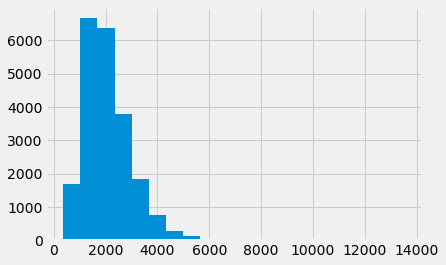

In [183]:
# look at distribution of house_df['sqft_living']
house_df['sqft_living'].hist(bins=20)

### Converting logged and normalized coefficients to original value, does not provide a coefficient for the original data set.
* They provide a value that is near the mean of the data, not a coefficient.
    * The value is near the mean because the conversion from the normalized value to the logged value results in a value near the mean, as the normalized values center upon the mean.
* We would need to convert all of the values in the normalized data frame to logged, then find the inverse of the log, then run a summary.
    * At this point, we would be running a summary of the original data.

## Logged Model

### Model Summary

In [184]:
# Logged Values Model Summary
X_log = logged_df.drop(['price_log'], axis=1)
y_log = logged_df['price_log']

X_int = sm.add_constant(X_log)
model = sm.OLS(y_log,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     1647.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:22:32   Log-Likelihood:                -7112.6
No. Observations:               21597   AIC:                         1.427e+04
Df Residuals:                   21577   BIC:                         1.442e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  86.5273      1.530     56.539      0.000      83.528      89.527
sqft_living_log         0.6561      0.010     63.966      0.000       0.636       0.676
bathrooms_log           0.1430      0.011     13.547      0.000       0.122       0.164
bedrooms_log           -0.2453      0.011    -22.457      0.000      -0.267      -0.224
yr_built_log          -10.3301      0.201    -51.446      0.000     -10.724      -9.937
floors_log              0.1695      0.008     21.128      0.000       0.154       0.185
water_1.0               0.3119      0.034      9.149      0.000       0.245       0.379
view_EXCELLENT          0.3434      0.024     14.606      0.000       0.297       0.390
view_FAIR               0.1918      0.019     10.200      0.000       0.155       0.229
view_GOOD               0.1885      0.015     12.221      0.000       0.158       0.219
condition_Fair         -0.1693      0.026     -6.475      0.000      -0.221      -0.118
condition_Very Good     0.0688      0.009      7.772      0.000       0.051       0.086
grade_11 Excellent      0.5771      0.019     31.136      0.000       0.541       0.613
grade_12 Luxury         0.7428      0.037     20.084      0.000       0.670       0.815
grade_13 Mansion        1.0076      0.094     10.707      0.000       0.823       1.192
grade_4 Low            -0.3133      0.065     -4.787      0.000      -0.442      -0.185
grade_5 Fair           -0.3472      0.023    -15.411      0.000      -0.391      -0.303
grade_6 Low Average    -0.2003      0.009    -22.311      0.000      -0.218      -0.183
grade_8 Good            0.0911      0.006     15.678      0.000       0.080       0.103
grade_9 Better          0.2674      0.008     32.008      0.000       0.251       0.284
==============================================================================
Omnibus:                       44.228   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.436
Skew:                           0.060   Prob(JB):                     1.12e-11
Kurtosis:                       3.204   Cond. No.                     7.31e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Interpretation of Coefficients - Percent Change
* Not using this model because it did not meet the assumptions of linearity, but it is helpful to compare the amounts to check that the final model is performing correctly.
***
* For log value coefficients, a percent change can reliably be calculated.
    * https://stats.oarc.ucla.edu/sas/faq/how-can-i-interpret-log-transformed-variables-in-terms-of-percent-change-in-linear-regression
* More helpful for continuous numerical values, such as sqft_living
***
* For every 1% increase in price:
    * Sqft_living will increase by 0.66%
    * Bathrooms will increase by 0.14%
    * Bedrooms will decrease by 0.25%
    * Year Built will decrease by 10.33%
    * Floors will increase by 0.17%
    

# Recommendations

## Renovate Interior
* Grade and Condition score increases were correlated to large price increases.
* Spending on an interior renovation, especially in regards to the whole house being considered very good to luxury is likely to increase sale price.

## Create a View
* Add larger windows that face pleasant scenery.
* Add a deck or rooftop deck to enhance access to outdoor views.
* Landscape and design views from windows to include desirable plants and scenery.

## Add Square Footage
* Add liveable space in your home.
* Not necessarily bedrooms or bathrooms, though it is better to add bathrooms, in terms of sale price.
* Renovate Garage to be fully insulated livable space.
* Add a guest cottage with full pluming, electrical, and HVAC.


# Further Studies Recommended

## Examine other housing data sets to determine if they contain similar trends to predictors in the King County Data Set.

## Find additional predictors to better estimate how much certain home changes alter sale price. 
* Type of remodel or home additions.
    * Ex. Kitchen, Garage, Patio, additional Bedrooms/Bathrooms.

## Estimate return on investment for renovations.
* How do certain projects increase sale price?
    * Example: Is it better to convert a garage to livable space or update a bathroom?
* What amount of spending that reaps a higher gain for a given project?